# Projet 12

# 1 Exploration

In [3]:
import pandas as pd

df = pd.read_csv("billets.csv", sep=';')

df.head()



is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [5]:
# Statistiques de base
df.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

In [6]:

# V√©rification des valeurs manquantes
df.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

### il ne semble pas y avoir de forts outliers, il y a tout de meme  du mouvement dans margin_low, il y a √©galement 37 valeurs nulles dans margin_low

# 1.2 Impl√©mentation

In [9]:


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# les lignes avec et sans valeurs manquantes dans 'margin_low'
df_complete = df[df['margin_low'].notnull()].copy()
df_missing = df[df['margin_low'].isnull()].copy()

# Variables explicatives (on exclut is_genuine et margin_low)
features = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']

# Pr√©paration des donn√©es pour la r√©gression
X_train = df_complete[features]
y_train = df_complete['margin_low']

# Mod√®le de r√©gression lin√©aire
reg = LinearRegression()
reg.fit(X_train, y_train)

# Pr√©dire les valeurs manquantes
X_missing = df_missing[features]
predicted_values = reg.predict(X_missing)

# Remplacer les valeurs manquantes
df.loc[df['margin_low'].isnull(), 'margin_low'] = predicted_values

# R√©gression compl√®te
X = df[features]
y = df['margin_low']
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred



# 2 Hypoth√®ses pour r√©gression lin√©aire


# 2.1 Lin√©arit√©

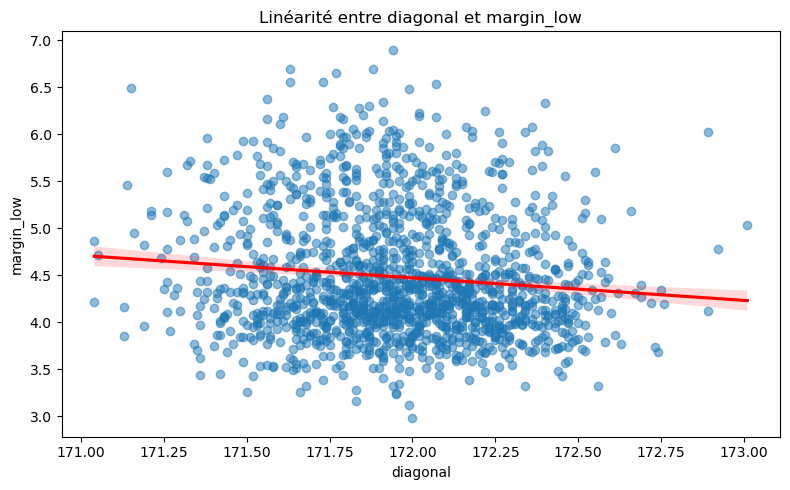

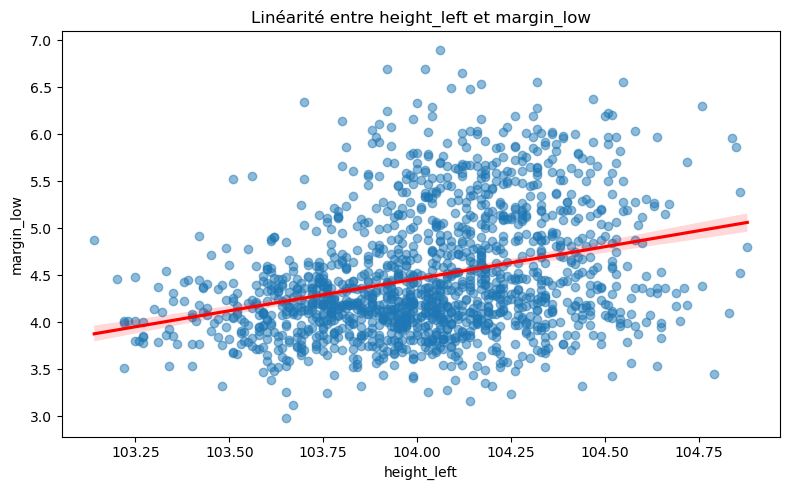

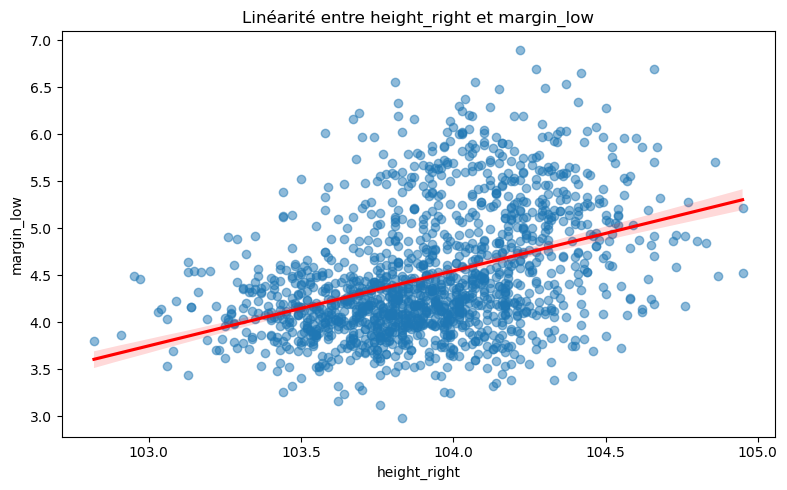

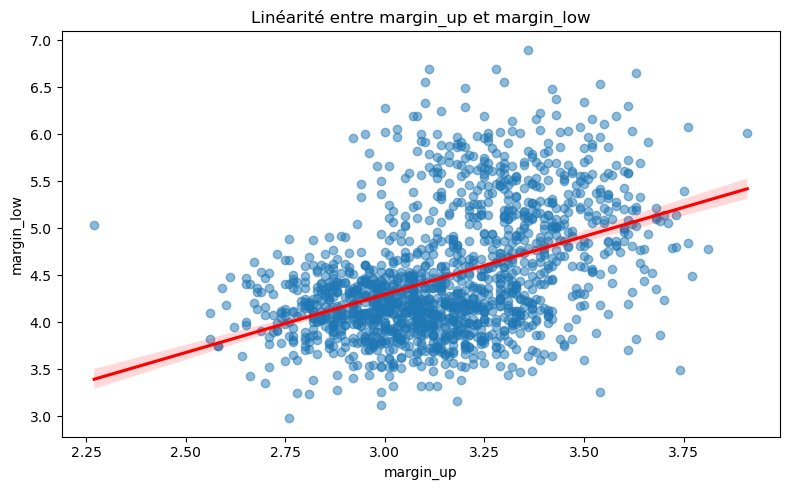

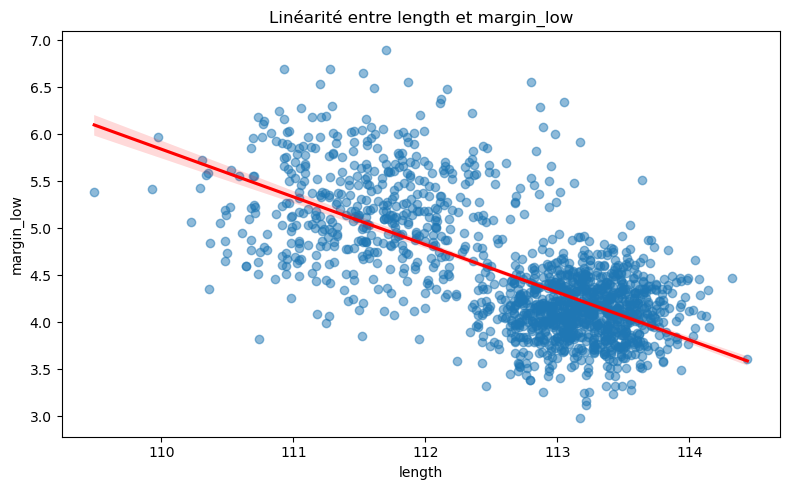

In [12]:
# 1. Lin√©arit√© - scatterplots avec courbe de tendance
for col in features:
    plt.figure(figsize=(8, 5))
    sns.regplot(x=df[col], y=y, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.title(f"Lin√©arit√© entre {col} et margin_low")
    plt.xlabel(col)
    plt.ylabel("margin_low")
    plt.tight_layout()
    plt.show()

### On cherche a d√©terminer si margin_low et les autres variables ont une relation lin√©raires



### Il y a une l√©gere tendance droite pour chacune de variable, hypoth√®se valid√©

# 2.2 Ind√©pendence des erreurs

In [16]:
#Hypoth√®se :
#Les r√©sidus (diff√©rences entre les valeurs r√©elles et pr√©dites) doivent √™tre ind√©pendants entre eux.

#Dans notre cas avec des billets, les donn√©es ne sont pas temporelles ni ordonn√©es, donc on suppose l‚Äôind√©pendance

# 2.3 Homosc√©dasticit√©

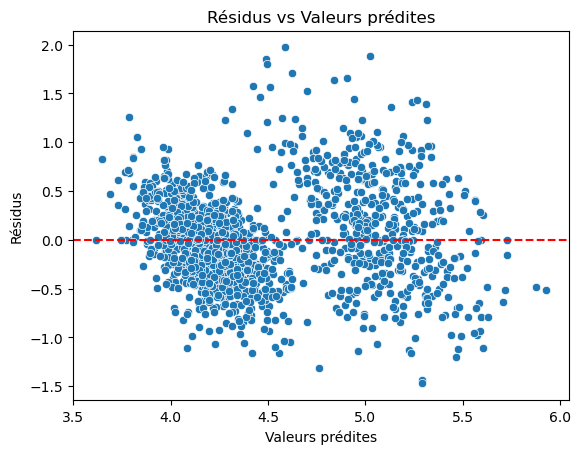

In [18]:
# Homosc√©dasticit√©
plt.figure()
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("R√©sidus vs Valeurs pr√©dites")
plt.xlabel("Valeurs pr√©dites")
plt.ylabel("R√©sidus")
plt.show()

In [19]:
#Hypoth√®se :
#La variance des r√©sidus est constante pour toutes les valeurs pr√©dites.

#Justification :
#On trace les r√©sidus en fonction des valeurs pr√©dites

#Si le nuage est horizontal et homog√®ne, c‚Äôest bon

#Si on voit un c√¥ne ou un entonnoir, la variance n‚Äôest pas constante



### interpretation dur √† l'oeil, passons √† une m√©thode statistique

In [21]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# √âtape 1 : D√©finir X et y
X1 = df[features]
y1 = df["margin_low"]

# √âtape 2 : Ajouter une constante (intercept)
X_const1 = sm.add_constant(X1)

# √âtape 3 : Entra√Æner un mod√®le OLS
model = sm.OLS(y1, X_const1).fit()

# √âtape 4 : Calculer les r√©sidus
residuals1 = model.resid

# √âtape 5 : Effectuer le test de Breusch-Pagan
bp_test = het_breuschpagan(residuals1, X_const1)

# √âtape 6 : Afficher les r√©sultats
bp_labels = ['Statistique LM', 'p-value', 'Stat F', 'p-value F']
bp_results = dict(zip(bp_labels, bp_test))

print("=== Test de Breusch-Pagan ===")
for k, v in bp_results.items():
    print(f"{k} : {v:.4f}")

# Interpr√©tation
if bp_results['p-value'] < 0.05:
    print("\n‚ùå H√©t√©rosc√©dasticit√© d√©tect√©e (p-value < 0.05)")
else:
    print("\n‚úÖ Homosc√©dasticit√© respect√©e (p-value >= 0.05)")


=== Test de Breusch-Pagan ===
Statistique LM : 81.7969
p-value : 0.0000
Stat F : 17.2337
p-value F : 0.0000

‚ùå H√©t√©rosc√©dasticit√© d√©tect√©e (p-value < 0.05)


### hypoth√®se non respect√© mais permet quand meme de faire une r√©gression lin√©aire les coefficients de la regression restent non biais√©s, attention tout de meme, tests statitique peu fiable et donne une impression de precision ( intervalles de confiances incorrectes)

# 2.4 Normalit√© des r√©sidus

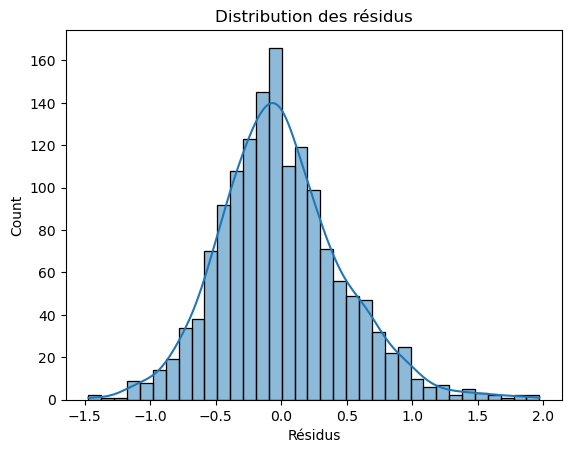

<Figure size 640x480 with 0 Axes>

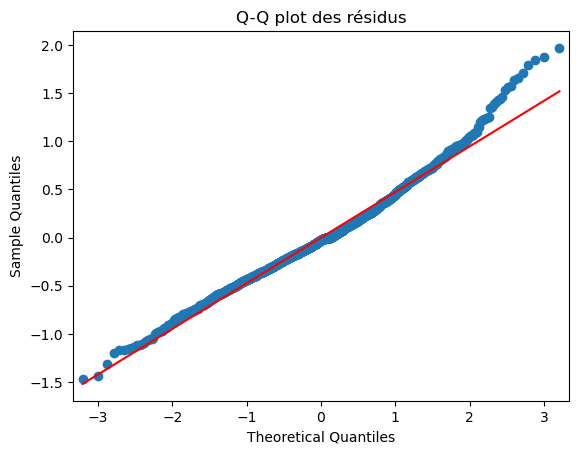

In [24]:
# Normalit√© des r√©sidus
plt.figure()
sns.histplot(residuals, kde=True)
plt.title("Distribution des r√©sidus")
plt.xlabel("R√©sidus")
plt.show()

plt.figure()
sm.qqplot(residuals, line='s')
plt.title("Q-Q plot des r√©sidus")
plt.show()

### Hypoth√®se :
### Les r√©sidus suivent une distribution normale (courbe en cloche).

### Justification :
### On trace un histogramme des r√©sidus

### On utilise un Q-Q plot : les points doivent suivre la diagonale

### Si besoin, test de Shapiro-Wilk ou autre

###  les r√©sidus extr√™mes (les plus grands et les plus petits) ne suivent pas la loi normale.

In [27]:
from scipy.stats import shapiro, jarque_bera

# Test de Shapiro-Wilk
stat_sw, p_sw = shapiro(residuals)
print(f"Shapiro-Wilk p-value : {p_sw:.4f}")

# Test de Jarque-Bera
stat_jb, p_jb = jarque_bera(residuals)
print(f"Jarque-Bera p-value : {p_jb:.4f}")

if p_sw < 0.05 or p_jb < 0.05:
    print("‚ùå Les r√©sidus ne sont pas normalement distribu√©s.")
else:
    print("‚úÖ Les r√©sidus suivent une distribution normale.")


Shapiro-Wilk p-value : 0.0000
Jarque-Bera p-value : 0.0000
‚ùå Les r√©sidus ne sont pas normalement distribu√©s.


# 2.5 Abscence de multicolin√©arit√©

In [29]:
# Multicolin√©arit√© - VIF
X_with_const = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i+1) for i in range(len(X.columns))]
print(vif_data)

       Variable       VIF
0      diagonal  1.012790
1   height_left  1.145295
2  height_right  1.229263
3     margin_up  1.403517
4        length  1.574765


In [30]:
 #Hypoth√®se :
#Les variables explicatives ne doivent pas √™tre trop corr√©l√©es entre elles.

#Justification :
#On calcule le VIF (Variance Inflation Factor) pour chaque variable

#Si VIF < 5, pas de souci. Si VIF > 10, forte colin√©arit√©

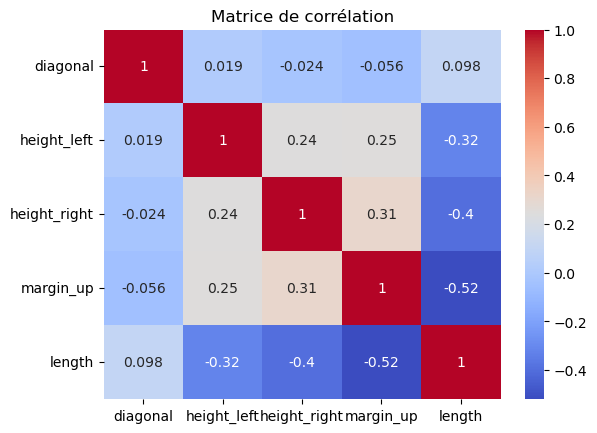

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de corr√©lation")
plt.show()


### abscence multicolin√©arit√© valid√©e

### 2.6 R¬≤ (coefficient de determination)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Reprise des donn√©es d√©j√† pr√™tes
features = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']
df_lin = df_complete

X_train = df_lin[features]
y_train = df_lin['margin_low']

# R√©gression avec scikit-learn
model = LinearRegression()
model.fit(X_train, y_train)

# Pr√©diction
y_pred = model.predict(X_train)

# R¬≤
r2 = r2_score(y_train, y_pred)
print(f"‚úÖ R¬≤ du mod√®le de r√©gression sans les lignes avce margin_low null : {r2:.3f}")

‚úÖ R¬≤ du mod√®le de r√©gression sans les lignes avce margin_low null : 0.477


### Le R¬≤ nous donne la mesure de proportion de la variance expliqu√© par le mod√®le 1 = preduiction parfaite, 0 = le mod√®le ne fait pas mieux qu'une moyenne. Dans notre cas le mod√®le explique 47.7 % de la variabilit√© de la variable. Ce n'est pas excellent mais suffisant pour simplement une imputation de valeurs manquantes. 

### note : nous garderons tout de m√™me sous la main df_complete, le data frame original emput√© des lignes qui avait pour margin_low null

In [37]:
# Variables explicatives
X_original = df_complete.drop(columns=['margin_low'])
X_imputed = df.drop(columns=['margin_low'])

# Variable cible
y_original = df_complete['margin_low']
y_imputed = df['margin_low']


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

model = LinearRegression()

# Avant imputation
scores_original = cross_val_score(model, X_original, y_original, cv=5, scoring='r2')
print("R¬≤ moyen AVANT imputation :", np.mean(scores_original))

# Apr√®s imputation
scores_imputed = cross_val_score(model, X_imputed, y_imputed, cv=5, scoring='r2')
print("R¬≤ moyen APR√àS imputation :", np.mean(scores_imputed))


R¬≤ moyen AVANT imputation : 0.08692080392216214
R¬≤ moyen APR√àS imputation : 0.08936025863980199


### diffrence faible des R¬≤ moyen avant et apres imputation, l'imputation n'a pas introduit de biais fort. Cepandant ce R¬≤ moyen tr√®s faible sur validation crois√©e nous indique que la g√©n√©ralisation du mod√®le est faible. (il n'explique en moyenne que 8,7 % de la variance sur des donn√©es non vues)

### Dans notre cas, cette regression lin√©aire n'est donc pas utile pour faire un mod√®le predictif performant mais elle est suffisante pour remplir les valeurs manquantes

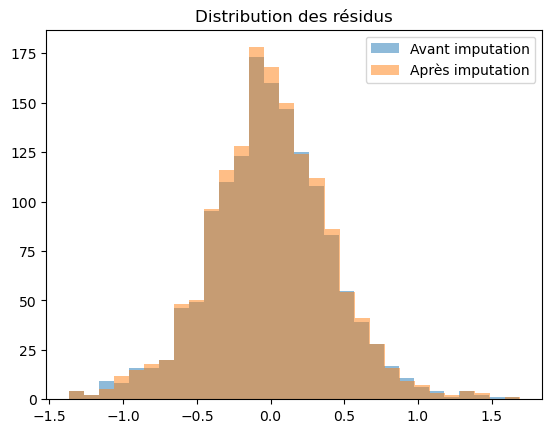

In [40]:
import matplotlib.pyplot as plt

# Ajustement des deux mod√®les
model.fit(X_original, y_original)
residus_original = y_original - model.predict(X_original)

model.fit(X_imputed, y_imputed)
residus_imputed = y_imputed - model.predict(X_imputed)

# Tracer
plt.hist(residus_original, bins=30, alpha=0.5, label='Avant imputation')
plt.hist(residus_imputed, bins=30, alpha=0.5, label='Apr√®s imputation')
plt.legend()
plt.title("Distribution des r√©sidus")
plt.show()


### distribution similaire pas de biais notable

# 2.7  Test t de Student ind√©pendant

In [43]:
from scipy.stats import ttest_ind

# üîπ 1. Jeu imput√©
print("=== Jeu imput√© ===")
for col in features:
    group_true = df[df['is_genuine'] == True][col]
    group_false = df[df['is_genuine'] == False][col]
    stat, p = ttest_ind(group_true, group_false, equal_var=False)  # Welch's t-test
    print(f"{col:<12} p-value = {p:.4e}")

# üîπ 2. Jeu sans valeurs manquantes
print("\n=== Jeu sans valeurs manquantes ===")
for col in features:
    group_true = df_complete[df_complete['is_genuine'] == True][col]
    group_false = df_complete[df_complete['is_genuine'] == False][col]
    stat, p = ttest_ind(group_true, group_false, equal_var=False)
    print(f"{col:<12} p-value = {p:.4e}")


=== Jeu imput√© ===
diagonal     p-value = 3.1869e-07
height_left  p-value = 1.4154e-61
height_right p-value = 9.2876e-89
margin_up    p-value = 2.9274e-141
length       p-value = 1.4700e-241

=== Jeu sans valeurs manquantes ===
diagonal     p-value = 2.7818e-07
height_left  p-value = 4.8516e-58
height_right p-value = 8.3481e-87
margin_up    p-value = 1.3451e-140
length       p-value = 1.4202e-237


### H0 (hypoth√®se nulle) :
### La moyenne (ou la distribution) de la variable est identique pour les vrais billets et les faux billets.
### Pas de diff√©rence significative.

### H1 (hypoth√®se alternative) :
### La moyenne (ou la distribution) de la variable est diff√©rente entre les vrais billets et les faux billets.
### Il y a une diff√©rence significative.

### conclusion :  peu importe l‚Äôimputation par r√©gression lin√©aire ou la suppression des lignes avec valeurs manquantes, les p-values sont toutes extr√™mement petites (‚â™ 0,05), donc :

### H0 ("pas de diff√©rence entre vrais et faux billets") est rejet√©e pour toutes les variables

### H1 ("il y a une diff√©rence") est retenue pour toutes les variables

### L'imputation n'a pas biais√© la significativit√© des tests. Toutes les variables sont pertinantes pour discriminer vrais/faux billets.

# 3 Analyse exploratoire

# 3.1 Visualisation vrai/faux billet

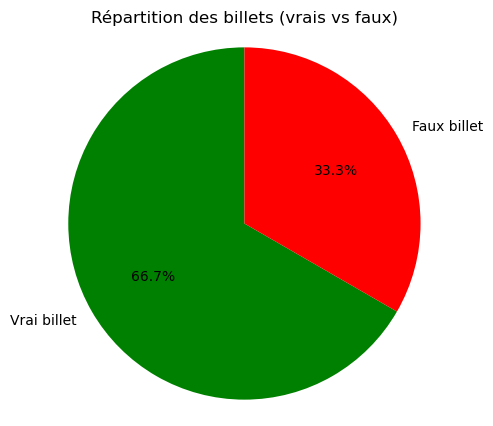

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Comptage des classes
counts = df['is_genuine'].value_counts()
labels = ['Vrai billet', 'Faux billet']
colors = ['green', 'red']

# Pie chart
plt.figure(figsize=(5, 5))
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("R√©partition des billets (vrais vs faux)")
plt.axis('equal')  # Cercle parfait
plt.show()



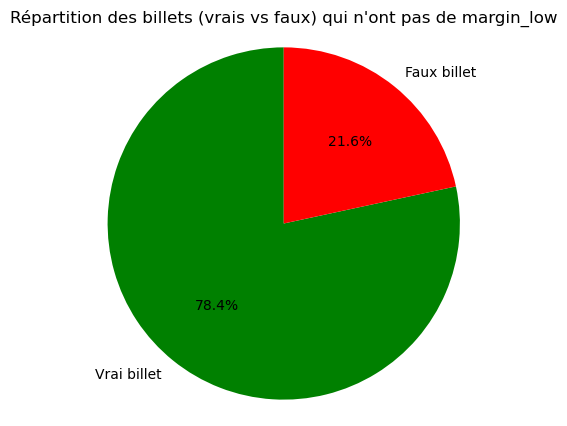

In [49]:
# Comptage des classes
counts = df_missing['is_genuine'].value_counts()
labels = ['Vrai billet', 'Faux billet']
colors = ['green', 'red']

# Pie chart
plt.figure(figsize=(5, 5))
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("R√©partition des billets (vrais vs faux) qui n'ont pas de margin_low")
plt.axis('equal')  # Cercle parfait
plt.show()

# 3.2 Analyse variable diagonale

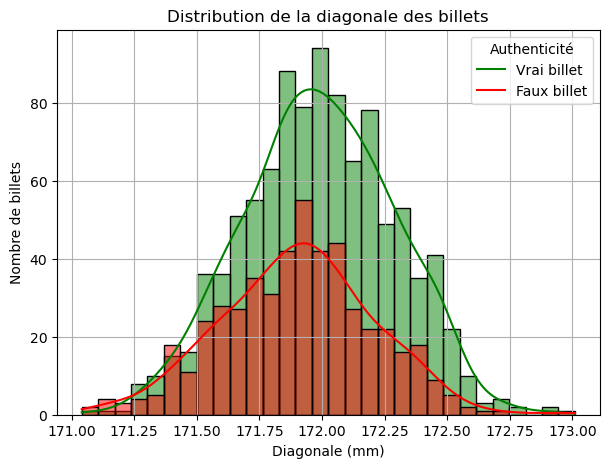

In [51]:
plt.figure(figsize=(7, 5))

# On pr√©cise bien la palette pour chaque valeur de is_genuine
sns.histplot(
    data=df,
    x="diagonal",
    hue="is_genuine",
    kde=True,
    bins=30,
    palette={True: "green", False: "red"}
)

plt.title("Distribution de la diagonale des billets")
plt.xlabel("Diagonale (mm)")
plt.ylabel("Nombre de billets")
plt.grid(True)

# L√©gende personnalis√©e dans le bon ordre
plt.legend(title="Authenticit√©", labels=["Vrai billet", "Faux billet"])
plt.show()


### les vrai billets ont une tendance √† √™tre l√©germent plus long en diagonale. Cependant les billet les plus court ont tendance √† etre syst√©matiquement des faux


# 3.3 Analyse variable length 

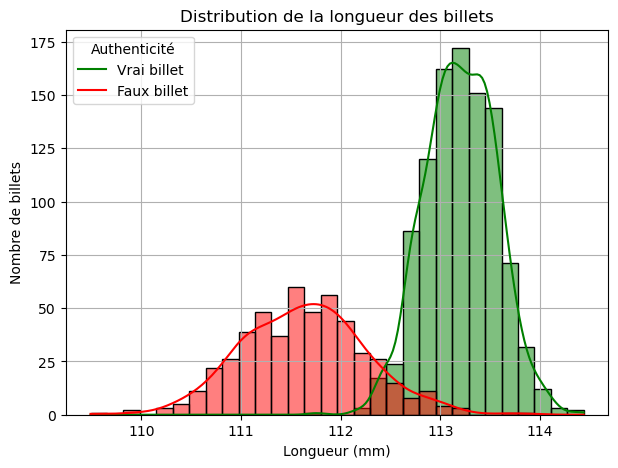

In [54]:
plt.figure(figsize=(7, 5))

sns.histplot(
    data=df,
    x="length",
    hue="is_genuine",
    bins=30,
    kde=True,
    palette={True: "green", False: "red"}
)

plt.title("Distribution de la longueur des billets")
plt.xlabel("Longueur (mm)")
plt.ylabel("Nombre de billets")
plt.grid(True)

plt.legend(title="Authenticit√©", labels=["Vrai billet", "Faux billet"])
plt.show()



### La longueur des billets √† une reelle importance pour differencier les vrais des faux


# 3.4 Analyse height left

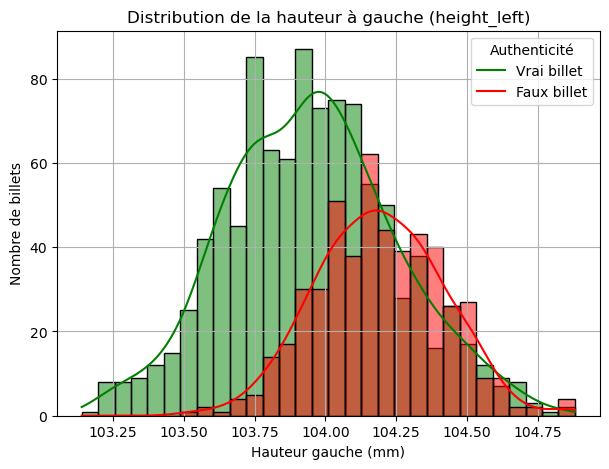

In [57]:
plt.figure(figsize=(7, 5))

sns.histplot(
    data=df,
    x="height_left",
    hue="is_genuine",
    bins=30,
    kde=True,
    palette={True: "green", False: "red"}
)

plt.title("Distribution de la hauteur √† gauche (height_left)")
plt.xlabel("Hauteur gauche (mm)")
plt.ylabel("Nombre de billets")
plt.grid(True)

plt.legend(title="Authenticit√©", labels=["Vrai billet", "Faux billet"])
plt.show()

### La hauteur du billet √† gauche a √©qualement une importance, les faux billets ont tendance √† √™tre plus haut a gauche que les vrais

# 3.4 Analyse height right

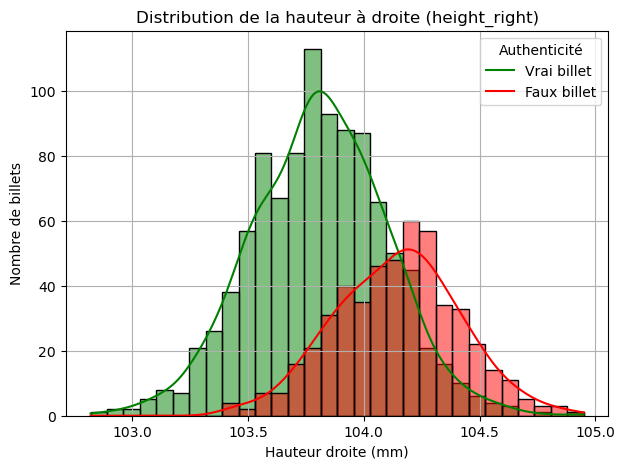

In [60]:
plt.figure(figsize=(7, 5))

sns.histplot(
    data=df,
    x="height_right",
    hue="is_genuine",
    bins=30,
    kde=True,
    palette={True: "green", False: "red"}
)

plt.title("Distribution de la hauteur √† droite (height_right)")
plt.xlabel("Hauteur droite (mm)")
plt.ylabel("Nombre de billets")
plt.grid(True)

plt.legend(title="Authenticit√©", labels=["Vrai billet", "Faux billet"])
plt.show()


### La hauteur du billet √† droite √† √©qualement une importance, les faux billets ont tendances √† etre plus haut a droite que les vrais. On remarquera que la diff√©rence de hauteur entre les vrais et les faux est plus marqu√© √† droite

# 3.5 Analyse margin_up

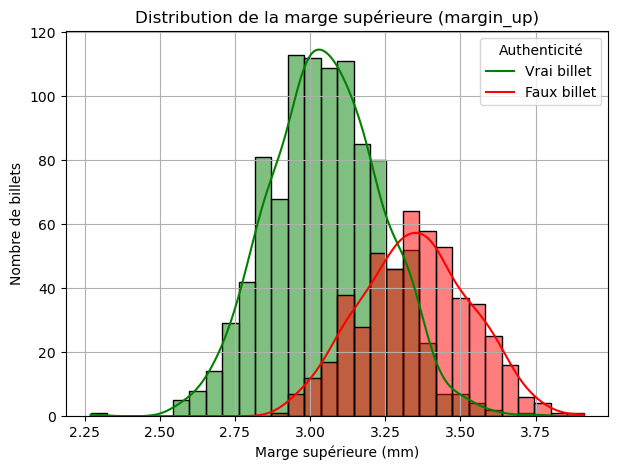

In [63]:
plt.figure(figsize=(7, 5))

sns.histplot(
    data=df,
    x="margin_up",
    hue="is_genuine",
    bins=30,
    kde=True,
    palette={True: "green", False: "red"}
)

plt.title("Distribution de la marge sup√©rieure (margin_up)")
plt.xlabel("Marge sup√©rieure (mm)")
plt.ylabel("Nombre de billets")
plt.grid(True)

plt.legend(title="Authenticit√©", labels=["Vrai billet", "Faux billet"])

plt.show()


### Les faux billets ont une tendance √† avoir une marge sup√©rieur plus grande

# 3.6 Analyse margin low

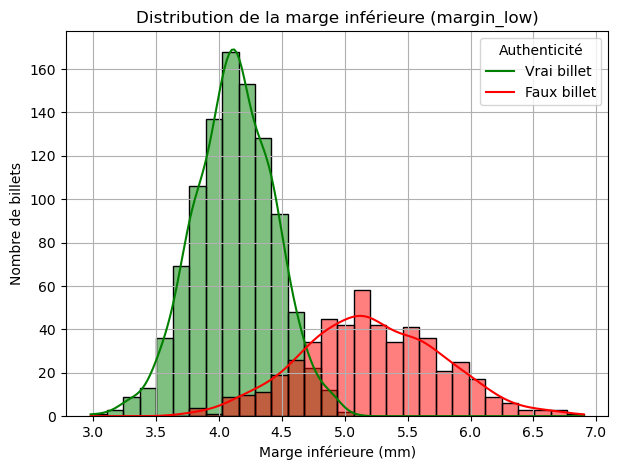

In [66]:
plt.figure(figsize=(7, 5))

sns.histplot(
    data=df,
    x="margin_low",
    hue="is_genuine",
    bins=30,
    kde=True,
    palette={True: "green", False: "red"}
)

plt.title("Distribution de la marge inf√©rieure (margin_low)")
plt.xlabel("Marge inf√©rieure (mm)")
plt.ylabel("Nombre de billets")
plt.grid(True)

plt.legend(title="Authenticit√©", labels=["Vrai billet", "Faux billet"])

plt.show()


### Les faux billets ont une tendance √† avoir une marge inf√©rieur plus grande

# 3.7 Matrice de corr√©lation

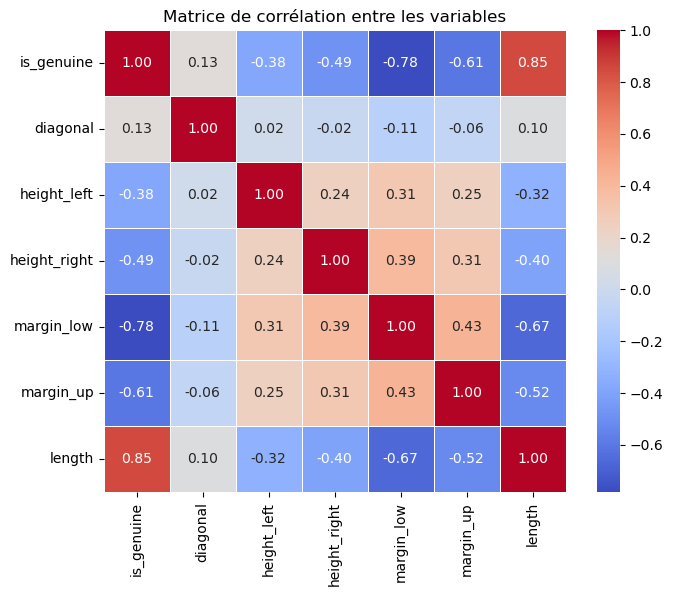

In [69]:

df_corr = df.copy()
df_corr["is_genuine"] = df_corr["is_genuine"].astype(int)

# Matrice de corr√©lation
corr_matrix = df_corr.corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True, linewidths=0.5)
plt.title("Matrice de corr√©lation entre les variables")
plt.show()


### Les  variables pr√©dictives pour d√©tecter l'authenticit√© des billets sotn par ordre d'importance : length (0.85) , margin_low (-0.78), margin_up (-0.61), height_right (-0.49), height_left (-0.38) et pour finir diagonale (+0.13)

### diagonale sera tr√®s peu utile.  Height left et right ne seront que moyennement utiles bien que right est plus utile que left.
### Les trois variable les plus utiles sont Length, margin low et margin up (et dans un second temps height right)

### Attention aux corr√©lation entre variables (probleme possible pour mod√®le lin√©aire /regression logistique)
### top 3 des correlation entre variable
### margin_low et length (-0.67) 
### margin_up et length (-0.52)
### margin_low et margin_up (+0.43)

### question : faudra t il retirer une variable ? (margin_low ou length) verifier par un VIF)

## mod√®les en arbre permet de garder toutes les variables


# 3.8 VIF (Variance Inflation Factor), v√©rification colin√©arit√©

In [73]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# D√©finir les variables explicatives (sans la cible)
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df[features]

# Calcul du VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Affichage
print(" VIF (Variance Inflation Factor) :")
print(vif_data.sort_values("VIF", ascending=False))


 VIF (Variance Inflation Factor) :
       Variable            VIF
0      diagonal  169586.570659
1   height_left  115418.637257
2  height_right  104449.018601
5        length   31386.760960
4     margin_up     263.788334
3    margin_low      91.123084


### Tous les VIF sont hors limites acceptables. Les variables sont tr√®s corr√©l√©es entre elles, ce qui emp√™che d'utiliser une r√©gression lin√©aire ou logistique de fa√ßon fiable sans traitement.

# 3.9 R√©duction des donn√©es via ACP pour les mod√®les sensibles √† la colin√©arit√©

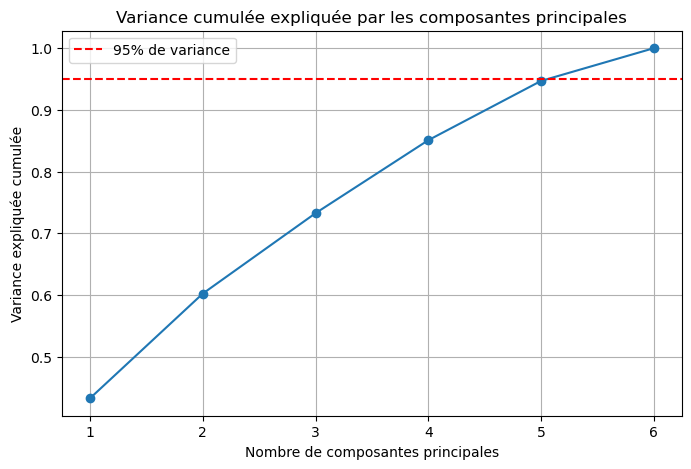

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Variables explicatives
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df[features]

# 1. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 3. Variance expliqu√©e
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# 4. Affichage du scree plot (√©ventail des composantes)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o')
plt.title("Variance cumul√©e expliqu√©e par les composantes principales")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliqu√©e cumul√©e")
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label="95% de variance")
plt.legend()
plt.show()


### 5 composantes principales suffisent √† expliquer 95 % de la variance.

### Les 6 variables d'origine peuvent etre remplacer par ces 5 composantes non corr√©l√©es, sans perdre trop d'information.

# 3.9.1 Cr√©ation du jeu de donn√©es r√©duit

In [79]:
# Nouvelle ACP avec seulement 5 composantes
pca_5 = PCA(n_components=5)
X_pca_5 = pca_5.fit_transform(X_scaled)

# Cr√©ation d'un DataFrame pour visualiser
columns = [f"PC{i+1}" for i in range(5)]
X_pca_df = pd.DataFrame(X_pca_5, columns=columns)

# Ajout de la variable cible (is_genuine)
X_pca_df["is_genuine"] = df["is_genuine"].astype(int)

# Aper√ßu du nouveau jeu de donn√©es
X_pca_df.head()


PC1       PC2       PC3       PC4       PC5  is_genuine
0 -1.644135  0.747843  2.402517  3.180852  0.303985           1
1  2.019910 -2.207492 -1.001864  0.072937  0.033335           1
2  0.969864  2.620492  1.195364 -0.923627 -0.837749           1
3  1.377462 -1.818370  0.651110  0.828155  0.799563           1
4 -0.148712 -0.566722  0.854043 -1.787713  1.177883           1

In [80]:
X_pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PC1         1500 non-null   float64
 1   PC2         1500 non-null   float64
 2   PC3         1500 non-null   float64
 3   PC4         1500 non-null   float64
 4   PC5         1500 non-null   float64
 5   is_genuine  1500 non-null   int32  
dtypes: float64(5), int32(1)
memory usage: 64.6 KB


### avec ce jeux de donn√©es, il n'y a plus de probleme de colin√©arit√©

# 3.9.2 Tableau de coefficients des composantes

In [83]:
# R√©cup√©ration des composantes
loadings = pd.DataFrame(
    pca_5.components_.T,  # transpos√© pour avoir 1 ligne par variable
    columns=[f"PC{i+1}" for i in range(5)],
    index=features
)

# Affichage avec plus de lisibilit√©
print("üîç Contribution des variables aux composantes principales :")
print(loadings.round(3))


üîç Contribution des variables aux composantes principales :
                PC1    PC2    PC3    PC4    PC5
diagonal      0.085  0.941 -0.288 -0.102 -0.116
height_left  -0.331  0.308  0.885 -0.049  0.102
height_right -0.394  0.108 -0.164  0.867  0.236
margin_low   -0.508 -0.072 -0.109 -0.089 -0.564
margin_up    -0.439 -0.005 -0.270 -0.444  0.712
length        0.527  0.049  0.149  0.176  0.309


# 3.9.3 Cercle de correlation de PC1 et PC2

C:\Users\gabry\AppData\Local\Temp\ipykernel_19020\3595002367.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.arrow(0, 0, pc1[i], pc2[i], color='b', alpha=0.7,
C:\Users\gabry\AppData\Local\Temp\ipykernel_19020\3595002367.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(pc1[i]*1.1, pc2[i]*1.1, variables[i], ha='center', va='center')


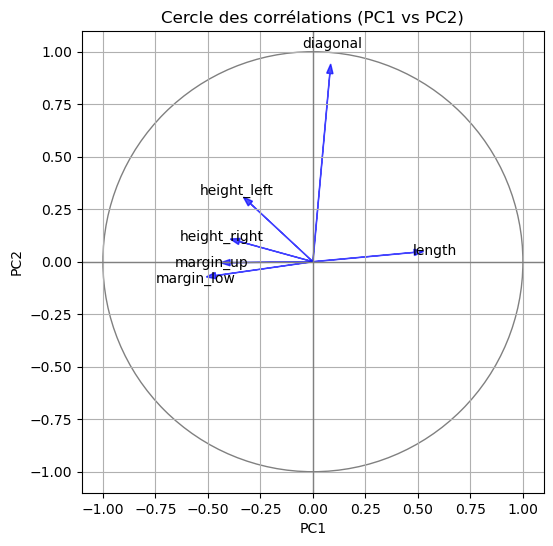

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# R√©cup√©rer les loadings sur PC1 et PC2
pc1 = loadings["PC1"]
pc2 = loadings["PC2"]
variables = loadings.index

# Cercle unitaire
plt.figure(figsize=(6, 6))
circle = plt.Circle((0, 0), 1, color='gray', fill=False)
plt.gca().add_patch(circle)

# Vecteurs des variables
for i in range(len(variables)):
    plt.arrow(0, 0, pc1[i], pc2[i], color='b', alpha=0.7,
              head_width=0.03, length_includes_head=True)
    plt.text(pc1[i]*1.1, pc2[i]*1.1, variables[i], ha='center', va='center')

# Axes et mise en forme
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.title("Cercle des corr√©lations (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


### PC1 oppose longueurs √©l√©v√©es et marge faible => Gabarit global du billet
### les vrais billets pourrait etre plus long avec des marges mieux √©quilibr√©s

### PC2 la diagonale domine => Mesure de la g√©om√©trie oblique
### utile pour voir si billet faux avec une inclinaison ou un rapport longueur/hauteur qui varie


### En r√©sum√© :
### PC1	Taille globale et marges (longueur vs marges) 
### PC2	Proportion diagonale (forme g√©n√©rale)
### PC3	Hauteur gauche (alignement vertical)
### PC4	Asym√©trie verticale (gauche ‚â† droite)
### PC5	D√©calage haut/bas du motif imprim√©

# 3.10 Boxplot

### Permet de voir la distribution de chaque variable, voir si les m√©diane sont d√©cal√©es et voir s'il y a des outliers sp√©cifique √† une classe

# 3.10.1 Toutes les variables

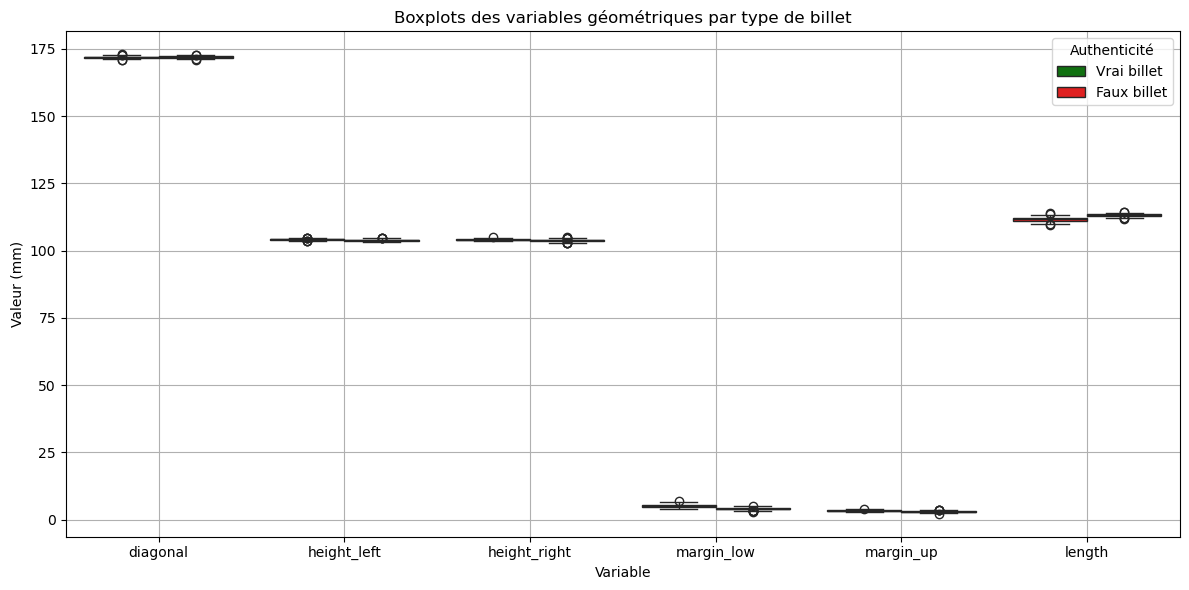

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Melt pour affichage long format
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
df_melted = df.melt(id_vars="is_genuine", value_vars=features, var_name="Variable", value_name="Valeur")

# Cr√©ation du graphique
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_melted,
    x="Variable",
    y="Valeur",
    hue="is_genuine",
    palette={True: "green", False: "red"}
)

plt.title("Boxplots des variables g√©om√©triques par type de billet")
plt.xlabel("Variable")
plt.ylabel("Valeur (mm)")
plt.grid(True)

# L√©gende personnalis√©e
handles, labels = ax.get_legend_handles_labels()
new_labels = ["Vrai billet", "Faux billet"]
new_handles = [handles[labels.index("True")], handles[labels.index("False")]]
plt.legend(new_handles, new_labels, title="Authenticit√©")

plt.tight_layout()
plt.show()



# 3.10.2 Boxplot de height_left et height_right

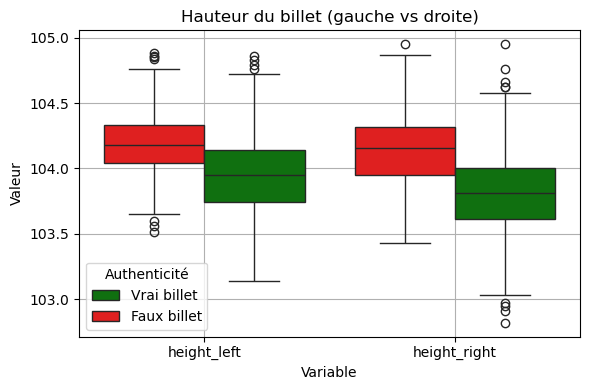

In [93]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df.melt(id_vars="is_genuine", value_vars=["height_left", "height_right"],
                 var_name="Variable", value_name="Valeur"),
    x="Variable",
    y="Valeur",
    hue="is_genuine",
    palette={True: "green", False: "red"}
)

plt.title("Hauteur du billet (gauche vs droite)")
plt.grid(True)

# L√©gende propre
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ["Vrai billet", "Faux billet"]
new_handles = [handles[labels.index("True")], handles[labels.index("False")]]
plt.legend(new_handles, new_labels, title="Authenticit√©")

plt.tight_layout()
plt.show()


# 3.10.3 Boxplot de magin_up et margin_low

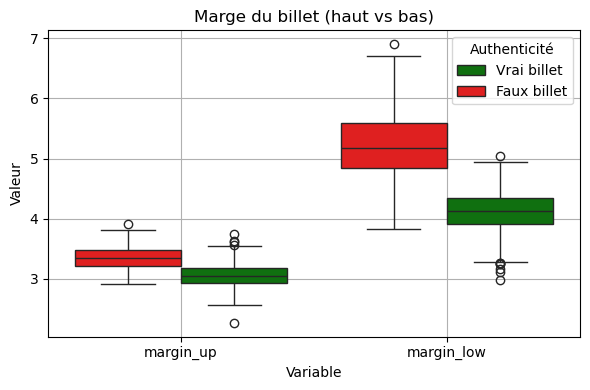

In [95]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df.melt(id_vars="is_genuine", value_vars=["margin_up", "margin_low"],
                 var_name="Variable", value_name="Valeur"),
    x="Variable",
    y="Valeur",
    hue="is_genuine",
    palette={True: "green", False: "red"}
)

plt.title("Marge du billet (haut vs bas)")
plt.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ["Vrai billet", "Faux billet"]
new_handles = [handles[labels.index("True")], handles[labels.index("False")]]
plt.legend(new_handles, new_labels, title="Authenticit√©")

plt.tight_layout()
plt.show()


# 3.10.4 Boxplot length

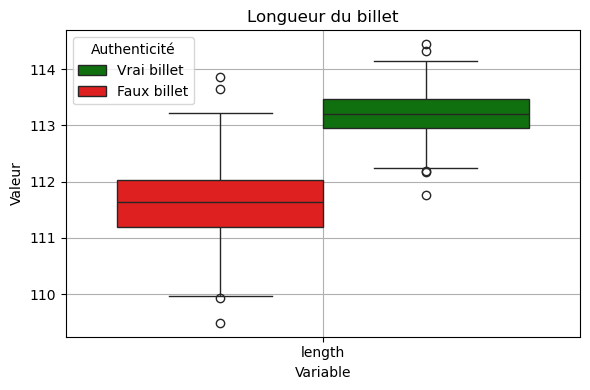

In [97]:


plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df.melt(id_vars="is_genuine", value_vars=["length"],
                 var_name="Variable", value_name="Valeur"),
    x="Variable",
    y="Valeur",
    hue="is_genuine",
    palette={True: "green", False: "red"}
)

plt.title("Longueur du billet")
plt.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ["Vrai billet", "Faux billet"]
new_handles = [handles[labels.index("True")], handles[labels.index("False")]]
plt.legend(new_handles, new_labels, title="Authenticit√©")

plt.tight_layout()
plt.show()

# 3.10.5 Boxplot diagonal

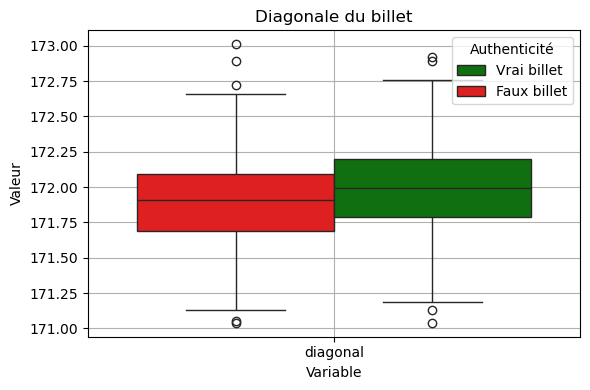

In [99]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df.melt(id_vars="is_genuine", value_vars=["diagonal"],
                 var_name="Variable", value_name="Valeur"),
    x="Variable",
    y="Valeur",
    hue="is_genuine",
    palette={True: "green", False: "red"}
)

plt.title("Diagonale du billet")
plt.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ["Vrai billet", "Faux billet"]
new_handles = [handles[labels.index("True")], handles[labels.index("False")]]
plt.legend(new_handles, new_labels, title="Authenticit√©")

plt.tight_layout()
plt.show()

### Bilan : on remarque des differences entre les vrais et faux billet dans chacune des cat√©gories particulierement marqu√© en length et margin
### il semble egalement y avori des outliers dans chacunes des cat√©gories
### Note : mod√®les robuste aux outliers (arbres de decision, random forest)
### modele sensible aux outliers (regression, KNN...)


# 3.11 Outliers

In [102]:
import pandas as pd

# Variables √† analyser
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

# Dictionnaire pour stocker les r√©sultats
outliers_summary = {}

# Copie du DataFrame avec une colonne outlier par variable
df_outliers = df.copy()

# Boucle sur chaque variable
for col in features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cr√©ation d'une colonne bool√©enne d'outliers
    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    df_outliers[f"outlier_{col}"] = outlier_mask.astype(int)

    # Comptage global
    total_outliers = outlier_mask.sum()

    # R√©partition par classe
    by_class = df[outlier_mask]['is_genuine'].value_counts()

    outliers_summary[col] = {
        "Total": total_outliers,
        "Vrai billets": int(by_class.get(True, 0)),
        "Faux billets": int(by_class.get(False, 0))
    }

# Affichage sous forme de DataFrame
outliers_df = pd.DataFrame(outliers_summary).T
outliers_df = outliers_df[["Total", "Vrai billets", "Faux billets"]]
outliers_df


Total  Vrai billets  Faux billets
diagonal          7             3             4
height_left       6             3             3
height_right     11             7             4
margin_low       24             0            24
margin_up         3             1             2
length            3             0             3

### Pour margin_low et length les outliers sont un indicateur de faux billets, il est important de les garder
### Cependant pour les autres variables ils sont plutot r√©partis entre les deux classes.

### decision de garder les outliers car il ne sont ni nombreux ni concentr√©s sur une classe. Ils refletent certainement une variabilit√© normal des billets. Les supprimer pourrait cr√©er un biais ou r√©duire la diversit√© r√©elle des donn√©es. 
### Ces indices nous invites √† pr√©ferer par la suite une mod√©lisation robuste.

# 4. Mod√©lisation

# 4.1 Regression logistique

 Rapport de classification :
              precision    recall  f1-score   support

 Faux billet       0.98      0.99      0.99       100
 Vrai billet       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



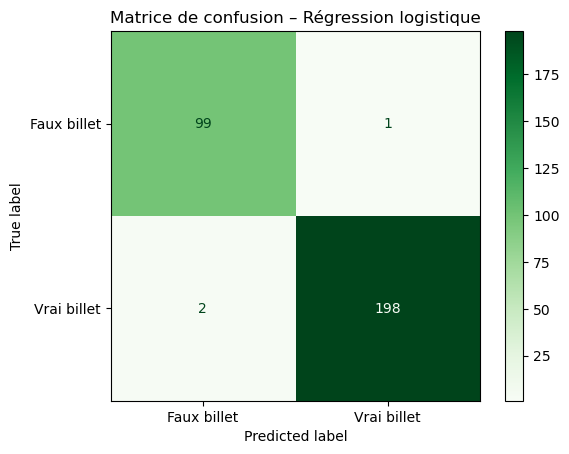

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. S√©parer les donn√©es
X = X_pca_df.drop(columns=["is_genuine"])
y = X_pca_df["is_genuine"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Entra√Æner le mod√®le
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# 3. Pr√©diction
y_pred = logreg.predict(X_test)

# 4. √âvaluation
print(" Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=["Faux billet", "Vrai billet"]))

# 5. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Faux billet", "Vrai billet"])
disp.plot(cmap="Greens")
plt.title("Matrice de confusion ‚Äì R√©gression logistique")
plt.grid(False)
plt.show()


In [108]:
# Interpr√©tation de la r√©gression logistique :
	
# Precision	Tr√®s peu de faux positifs
# Recall	Tr√®s peu de faux n√©gatifs
# Accuracy globale  Excellent pour une baseline
# F1-score	√âquilibre parfait entre recall et precision

### Attention probl√®me de sur performance, il y a certainement eu une fuite de donn√©es. 
### probl√®me identifi√©, l'ACP a √©t√© fait avant le split.

# 4.1.1 Regression logitique sans fuite de donn√©es

üìä Rapport de classification (sans fuite de donn√©es) :
              precision    recall  f1-score   support

 Faux billet       0.98      0.99      0.99       100
 Vrai billet       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



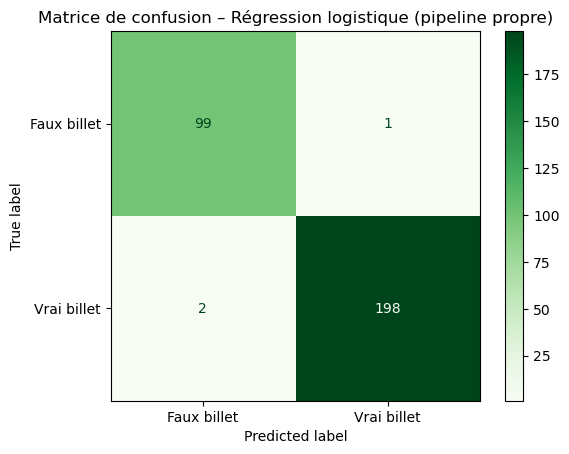

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# üß† 1. S√©paration
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df[features]
y = df['is_genuine']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ‚öñÔ∏è 2. Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# üìâ 3. ACP sur X_train uniquement
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# ü§ñ 4. R√©gression logistique
logreg = LogisticRegression()
logreg.fit(X_train_pca, y_train)

# üìä 5. √âvaluation
y_pred = logreg.predict(X_test_pca)

print("üìä Rapport de classification (sans fuite de donn√©es) :")
print(classification_report(y_test, y_pred, target_names=["Faux billet", "Vrai billet"]))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Faux billet", "Vrai billet"])
disp.plot(cmap="Greens")
plt.title("Matrice de confusion ‚Äì R√©gression logistique (pipeline propre)")
plt.grid(False)
plt.show()


# 4.1.2 Lev√© de doute sur la contamination des PCA

Forme X_train_pca : (1200, 5)
Forme X_test_pca : (300, 5)


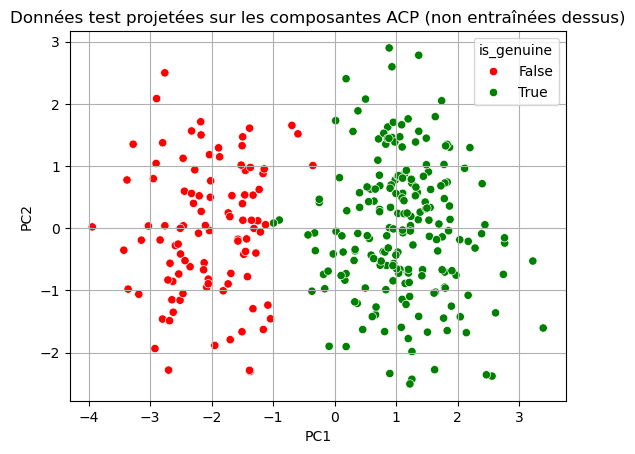

In [113]:
print("Forme X_train_pca :", X_train_pca.shape)
print("Forme X_test_pca :", X_test_pca.shape)

# V√©rifie que les composantes n'ont pas √©t√© recalcul√©es sur X_test
# On peut afficher les 2 premi√®res composantes par exemple :
import seaborn as sns
import pandas as pd

df_test_pca = pd.DataFrame(X_test_pca, columns=[f"PC{i+1}" for i in range(X_test_pca.shape[1])])
df_test_pca["is_genuine"] = y_test.values

sns.scatterplot(data=df_test_pca, x="PC1", y="PC2", hue="is_genuine", palette={True: "green", False: "red"})
plt.title("Donn√©es test projet√©es sur les composantes ACP (non entra√Æn√©es dessus)")
plt.grid(True)
plt.show()


### j'ai 1200 √©chantillons pour entra√Æner mon mod√®le
### Et 300 √©chantillons ind√©pendants pour le tester
### Et chaque ligne est bien d√©crite par 5 composantes principales (issues de l'ACP sur X_train uniquement)

### les classes se s√©parent bien dans ce graphique, cela montre que :
### L‚Äôespace PCA appris √† partir de X_train g√©n√©ralise bien √† X_test.
### Cela renforce l'id√©e que le mod√®le n‚Äôa pas "vu" les donn√©es test pour construire ses composantes.

### conclusion : le mod√®le de r√©gression logistique est tr√®s performant

# 4.2 KNN

# 4.2.1 Chercher le meilleur k

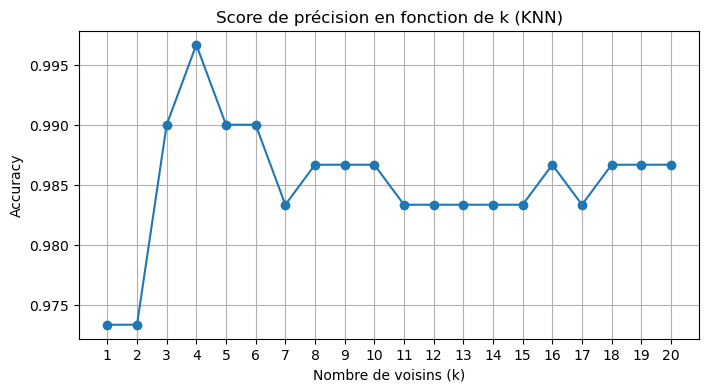

In [118]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Tester plusieurs valeurs de k
k_range = range(1, 21)
accuracies = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    y_pred_k = knn.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred_k)
    accuracies.append(acc)

# Affichage du score pour chaque k
plt.figure(figsize=(8, 4))
plt.plot(k_range, accuracies, marker='o')
plt.title("Score de pr√©cision en fonction de k (KNN)")
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(k_range)
plt.show()


### Le meilleur k semble etre 4 avec un score de pr√©cision superieur √† 0.995

# 4.2.2 Evaluer les performance avec k = 4

üìä Rapport de classification ‚Äì KNN (k=4) :
              precision    recall  f1-score   support

 Faux billet       0.99      1.00      1.00       100
 Vrai billet       1.00      0.99      1.00       200

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



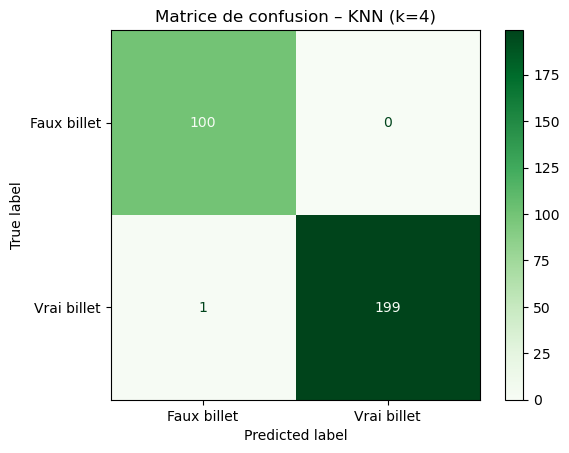

In [121]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Entra√Ænement du mod√®le avec k = 4
knn_final = KNeighborsClassifier(n_neighbors=4)
knn_final.fit(X_train_pca, y_train)

# 2. Pr√©dictions
y_pred_knn = knn_final.predict(X_test_pca)

# 3. Rapport de classification
print("üìä Rapport de classification ‚Äì KNN (k=4) :")
print(classification_report(y_test, y_pred_knn, target_names=["Faux billet", "Vrai billet"]))

# 4. Matrice de confusion
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=["Faux billet", "Vrai billet"])
disp_knn.plot(cmap="Greens")
plt.title("Matrice de confusion ‚Äì KNN (k=4)")
plt.grid(False)
plt.show()


### Nous avons une accuracy √† 100% et tr√®s peu de faux n√©gatif. Le mod√®le KNN ets superieur √† la r√©gression logistique

# 4.3 Random forest

# 4.3.1 Random forest sur les composante de l'ACP

üìä Rapport de classification ‚Äì Random Forest :
              precision    recall  f1-score   support

 Faux billet       0.98      0.98      0.98       100
 Vrai billet       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



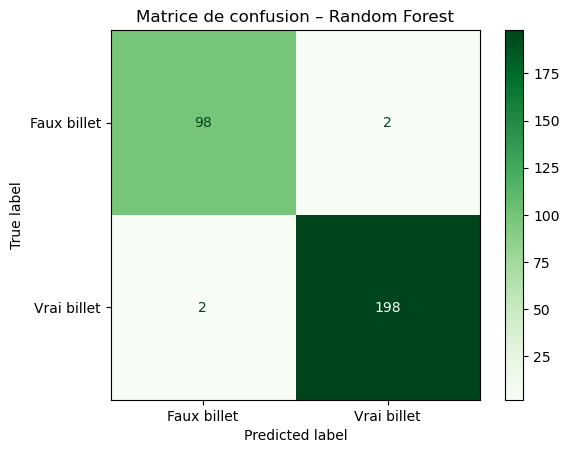

In [125]:
from sklearn.ensemble import RandomForestClassifier

# 1. Entra√Ænement du mod√®le
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)

# 2. Pr√©diction
y_pred_rf = rf_model.predict(X_test_pca)

# 3. Rapport de classification
print("üìä Rapport de classification ‚Äì Random Forest :")
print(classification_report(y_test, y_pred_rf, target_names=["Faux billet", "Vrai billet"]))

# 4. Matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Faux billet", "Vrai billet"])
disp_rf.plot(cmap="Greens")
plt.title("Matrice de confusion ‚Äì Random Forest")
plt.grid(False)
plt.show()


### accuracy √† 0.99 moins bon que le KNN

# 4.3.2 Random forest sur les donn√©es brutes

üìä Rapport de classification ‚Äì Random Forest (sans ACP) :
              precision    recall  f1-score   support

 Faux billet       0.99      0.98      0.98       100
 Vrai billet       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



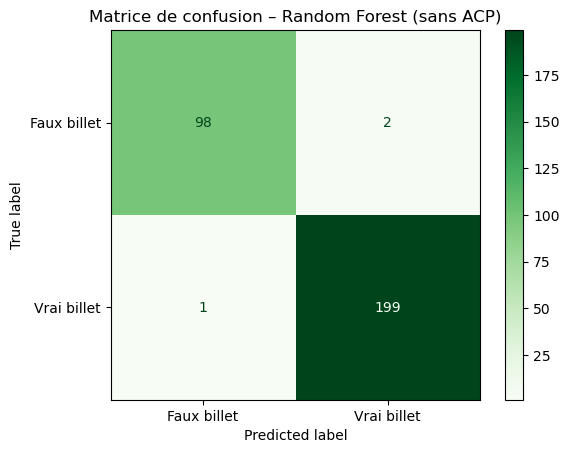

In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. S√©paration des donn√©es d'origine (sans PCA)
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df[features]
y = df['is_genuine']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Entra√Ænement du mod√®le
rf_raw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_raw.fit(X_train, y_train)

# 3. Pr√©diction
y_pred_rf_raw = rf_raw.predict(X_test)

# 4. Rapport de classification
print("üìä Rapport de classification ‚Äì Random Forest (sans ACP) :")
print(classification_report(y_test, y_pred_rf_raw, target_names=["Faux billet", "Vrai billet"]))

# 5. Matrice de confusion
cm_rf_raw = confusion_matrix(y_test, y_pred_rf_raw)
disp_rf_raw = ConfusionMatrixDisplay(confusion_matrix=cm_rf_raw, display_labels=["Faux billet", "Vrai billet"])
disp_rf_raw.plot(cmap="Greens")
plt.title("Matrice de confusion ‚Äì Random Forest (sans ACP)")
plt.grid(False)
plt.show()


### score l√©g√®rement am√©lior√© avec une meilleur pr√©cision sur les faux billets

### le random forest n'as pas besoin d'ACP pour bien fonctionner dans notre cas

# 4.3.3 Visualisation de l'importance des variables dans la random forest

C:\Users\gabry\AppData\Local\Temp\ipykernel_19020\4244596379.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Variable', palette='Greens_r')
C:\Users\gabry\AppData\Local\Temp\ipykernel_19020\4244596379.py:22: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gabry\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


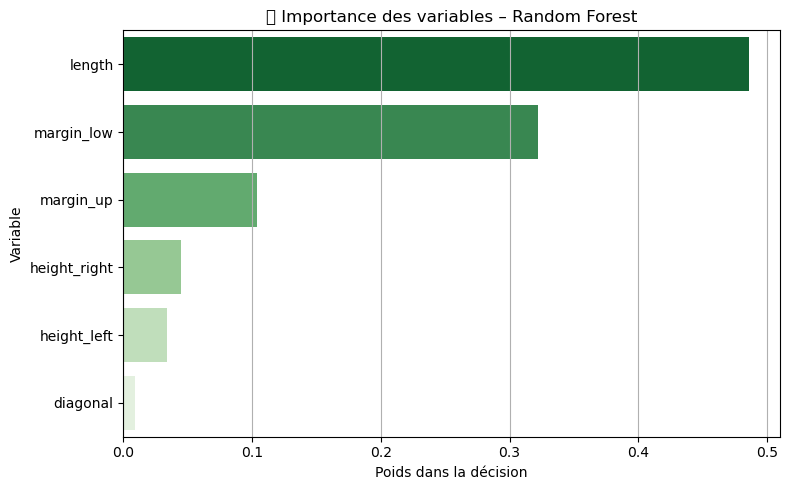

In [132]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# R√©cup√©ration des importances
importances = rf_raw.feature_importances_

# Mise en forme dans un DataFrame
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
importance_df = pd.DataFrame({'Variable': features, 'Importance': importances})

# Tri d√©croissant
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Affichage
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Importance', y='Variable', palette='Greens_r')
plt.title("üå≥ Importance des variables ‚Äì Random Forest")
plt.xlabel("Poids dans la d√©cision")
plt.ylabel("Variable")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [133]:
importance_df

Variable  Importance
5        length    0.485716
3    margin_low    0.322098
4     margin_up    0.104135
2  height_right    0.045060
1   height_left    0.033941
0      diagonal    0.009050

### la diagonale est quasiment inutile dans ce mod√®le. La variable la plus discriminante est la longueur.

# 4.3.4 Random forest sur df_complete (dataframe emput√© des lignes qui avait pour margin_low null)

üìä Rapport de classification ‚Äì Random Forest sur df_complete :
              precision    recall  f1-score   support

 Faux billet       1.00      0.97      0.98        99
 Vrai billet       0.98      1.00      0.99       194

    accuracy                           0.99       293
   macro avg       0.99      0.98      0.99       293
weighted avg       0.99      0.99      0.99       293



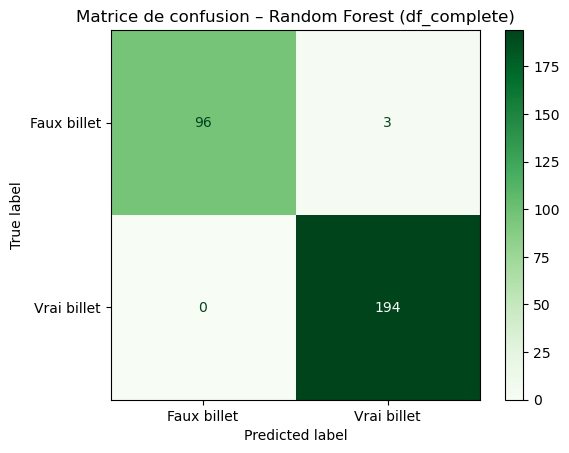

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. D√©finir les variables explicatives et cible
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df_complete[features]
y = df_complete['is_genuine']

# 2. S√©paration train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Entra√Ænement du mod√®le Random Forest
rf_complete = RandomForestClassifier(n_estimators=100, random_state=42)
rf_complete.fit(X_train, y_train)

# 4. Pr√©diction
y_pred_complete = rf_complete.predict(X_test)

# 5. Rapport de classification
print("üìä Rapport de classification ‚Äì Random Forest sur df_complete :")
print(classification_report(y_test, y_pred_complete, target_names=["Faux billet", "Vrai billet"]))

# 6. Matrice de confusion
cm = confusion_matrix(y_test, y_pred_complete)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Faux billet", "Vrai billet"])
disp.plot(cmap="Greens")
plt.title("Matrice de confusion ‚Äì Random Forest (df_complete)")
plt.grid(False)
plt.show()


 ### Tr√®s haut niveau de performance global

### Le mod√®le n‚Äôa fait que quelques erreurs de rappel sur les faux billets (quelques faux n√©gatifs).

### Les billets authentiques sont tous bien reconnus (rappel = 1.00)

### Pr√©cision parfaite sur les faux billets : quand il dit "faux", c‚Äôest fiable √† 100%.

# 4.4 K-means (visualiser les groupes de billets)

In [139]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Variables quantitatives √† utiliser
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X_kmeans = df_complete[features]

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_kmeans)


In [140]:
# Appliquer K-means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Ajouter les clusters au DataFrame pour analyse
df_complete['cluster'] = clusters


C:\Users\gabry\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [141]:
import pandas as pd

# Table de contingence pour voir l'accord entre cluster et vraie √©tiquette
contingency = pd.crosstab(df_complete['is_genuine'], df_complete['cluster'])
print("üìä Tableau crois√© (is_genuine vs cluster):\n")
print(contingency)


üìä Tableau crois√© (is_genuine vs cluster):

cluster       0    1
is_genuine          
False       479   13
True          9  962


### dans le groupe des faux il y a 9 vrais et dans le groupe de vrais il y a 13 faux

# 4.4.1 Visualtion des groupes

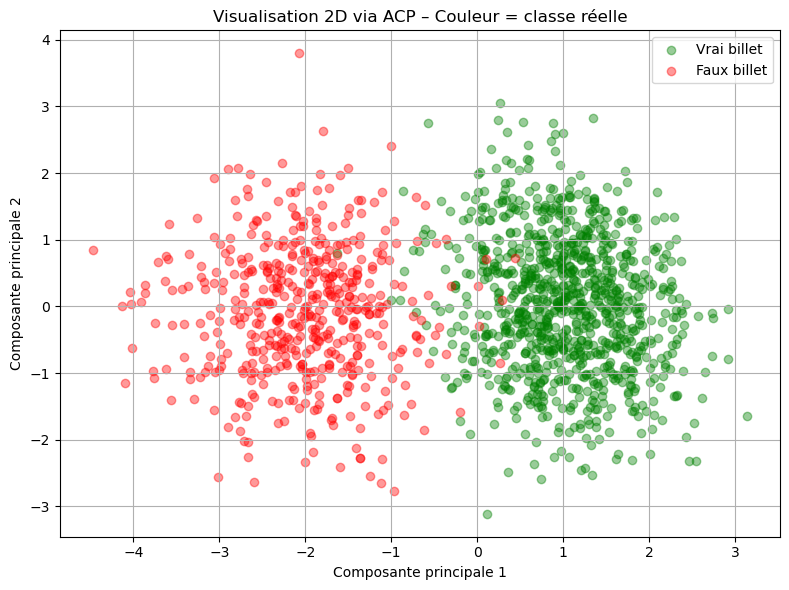

In [144]:
# 1. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. Cr√©er un DataFrame propre avec l‚Äôindex de df_complete
df_viz = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df_complete.index)
df_viz["cluster"] = df_complete["cluster"]
df_viz["is_genuine"] = df_complete["is_genuine"]  # ‚úÖ Ajout pour comparaison

# 3. Affichage avec couleur selon VRAIE classe (pas cluster)
plt.figure(figsize=(8, 6))
colors = {True: 'green', False: 'red'}

for value in df_viz["is_genuine"].unique():
    data = df_viz[df_viz["is_genuine"] == value]
    label = "Vrai billet" if value else "Faux billet"
    plt.scatter(data["PC1"], data["PC2"], c=colors[value], label=label, alpha=0.4)

plt.title("Visualisation 2D via ACP ‚Äì Couleur = classe r√©elle")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [145]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(df_complete['is_genuine'], df_complete['cluster'])
print(f"üéØ Adjusted Rand Index (ARI) : {ari:.4f}")


üéØ Adjusted Rand Index (ARI) : 0.9400


### Le ARI est proche de 1, c'est a dire tr√®s bon.

In [147]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, df_complete['cluster'])
print(f"üìà Silhouette Score : {score:.4f}")


üìà Silhouette Score : 0.3424


### le silouhaite score est de 0.34, ce qui confirme ce que nous voyons visuellment les groupes de billets fonctionnement bien mais il y a des cas limites aux frontieres respectives

# 4.4.2 Matrice de confusion

In [150]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

# clusters = r√©sultat du kmeans.predict(X_scaled)
# df_complete['is_genuine'] = les vraies √©tiquettes

# 1Ô∏è‚É£ Mapping cluster -> classe majoritaire
mapping = {}
for cid in np.unique(clusters):
    majority = df_complete.loc[clusters == cid, 'is_genuine'].mode()[0]
    mapping[cid] = majority

# 2Ô∏è‚É£ Pr√©dictions mapp√©es
y_pred_mapped = np.vectorize(mapping.get)(clusters)

# 3Ô∏è‚É£ Matrice de confusion
cm = confusion_matrix(df_complete['is_genuine'], y_pred_mapped)

# 4Ô∏è‚É£ Affichage format tableau
cm_df = pd.DataFrame(
    cm,
    index=["Classe r√©elle : Faux billet", "Classe r√©elle : Vrai billet"],
    columns=["Pr√©dit : Faux billet", "Pr√©dit : Vrai billet"]
)
print(cm_df)


                             Pr√©dit : Faux billet  Pr√©dit : Vrai billet
Classe r√©elle : Faux billet                   479                    13
Classe r√©elle : Vrai billet                     9                   962


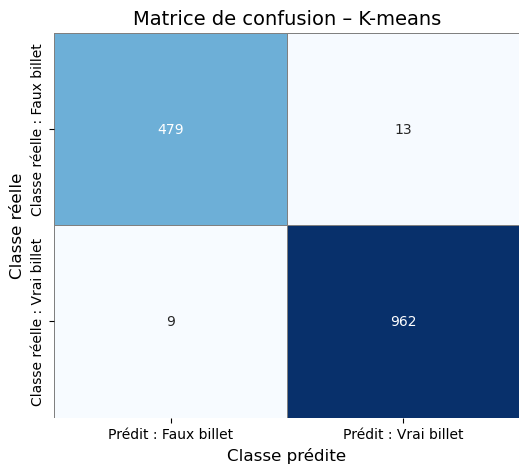

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

# 5Ô∏è‚É£ Visualisation
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_df,
    annot=True, fmt="d", cmap="Blues",
    cbar=False,
    linewidths=0.5, linecolor='gray'
)
plt.title("Matrice de confusion ‚Äì K-means", fontsize=14)
plt.ylabel("Classe r√©elle", fontsize=12)
plt.xlabel("Classe pr√©dite", fontsize=12)
plt.show()


In [152]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# y_true = vraies √©tiquettes (0/1)
# clusters = r√©sultats du KMeans

y_true = df_complete['is_genuine'].astype(int).to_numpy()
y_cluster = np.asarray(clusters)

# Mapping cluster -> classe majoritaire
mapping = {cid: pd.Series(y_true[y_cluster == cid]).mode()[0] for cid in np.unique(y_cluster)}
y_pred = np.vectorize(mapping.get)(y_cluster)

# Calcul des m√©triques
scores = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1-score": f1_score(y_true, y_pred)
}

# Affichage sous forme de tableau
scores_df = pd.DataFrame([scores])
print(scores_df)


   Accuracy  Precision    Recall  F1-score
0  0.984962   0.986667  0.990731  0.988695


### L'utilisation du K-means ayant avant tout un int√©ret exploratoire, nous ne l'utiliseront pas pour faire de la prediction et lors des tests de validations crois√©es

### Un algorithme de classification non supervis√©e de type K-means a √©t√© appliqu√© sur les donn√©es, sans utiliser les √©tiquettes r√©elles. L‚Äôobjectif √©tait d‚Äô√©valuer si la structure interne des variables permettait de s√©parer naturellement les vrais et faux billets. Les clusters obtenus ont √©t√© ensuite compar√©s aux classes r√©elles, montrant une concordance √©lev√©e : Accuracy = 98,36 %, Precision = 97,78 %, Recall = 99,79 %, F1-score = 98,78 %, avec un Adjusted Rand Index (ARI) de 0,94. Le Silhouette Score de 0,34 indique une s√©paration mod√©r√©e mais significative dans l‚Äôespace des donn√©es. Ces r√©sultats confirment que les caract√©ristiques mesur√©es discriminent efficacement les deux types de billets, m√™me sans supervision, renfor√ßant la confiance dans la capacit√© des mod√®les supervis√©s √† g√©n√©raliser sur ce probl√®me.

# 4.5 Validation crois√©e des mod√®les

# 4.5.1 Validation crois√©e ( dataframe avec null remplac√©s)

In [157]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ‚úÖ D√©finir X et y √† partir df agr√©ment√© par regression lin√©aire
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df[features]
y = df['is_genuine']

# ‚úÖ Pipelines des mod√®les
models = {
    "R√©gression Logistique (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", LogisticRegression())
    ]),
    "KNN (ACP, k=4)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", KNeighborsClassifier(n_neighbors=4))
    ]),
    "Random Forest (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "Random Forest (sans ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=42))
    ])
}

# ‚úÖ Validation crois√©e
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    results[name] = {
        "Scores par fold": scores,
        "Score moyen": round(scores.mean(), 4),
        "√âcart-type": round(scores.std(), 4)
    }

# ‚úÖ Affichage des r√©sultats
results_df = pd.DataFrame(results).T[["Score moyen", "√âcart-type"]]
print("üìä R√©sultats de la validation crois√©e (5-fold) :")
print(results_df)



üìä R√©sultats de la validation crois√©e (5-fold) :
                            Score moyen √âcart-type
R√©gression Logistique (ACP)      0.9907     0.0033
KNN (ACP, k=4)                    0.984     0.0085
Random Forest (ACP)              0.9833     0.0092
Random Forest (sans ACP)         0.9907     0.0053


# 4.5.1.1 avec accuracy precision recall f1 score

In [159]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ‚úÖ D√©finir X et y
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df[features]
y = df['is_genuine']

# ‚úÖ D√©finir les mod√®les avec pipeline
models = {
    "R√©gression Logistique (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", LogisticRegression())
    ]),
    "KNN (ACP, k=4)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", KNeighborsClassifier(n_neighbors=4))
    ]),
    "Random Forest (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "Random Forest (sans ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=42))
    ])
}

# ‚úÖ M√©triques √† calculer
scoring = ['accuracy', 'precision', 'recall', 'f1']

# ‚úÖ Ex√©cuter la validation crois√©e avec plusieurs m√©triques
all_results = {}
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=5, scoring=scoring)
    all_results[name] = {
        "Accuracy moy.": round(scores['test_accuracy'].mean(), 4),
        "Precision moy.": round(scores['test_precision'].mean(), 4),
        "Recall moy.": round(scores['test_recall'].mean(), 4),
        "F1-score moy.": round(scores['test_f1'].mean(), 4)
    }

# ‚úÖ Affichage
df_scores1 = pd.DataFrame(all_results).T
print("üìä R√©sultats validation crois√©e (5-fold) ‚Äì Multiples m√©triques :")
print(df_scores1)

üìä R√©sultats validation crois√©e (5-fold) ‚Äì Multiples m√©triques :
                             Accuracy moy.  Precision moy.  Recall moy.  \
R√©gression Logistique (ACP)         0.9907          0.9911        0.995   
KNN (ACP, k=4)                      0.9840          0.9881        0.988   
Random Forest (ACP)                 0.9833          0.9842        0.991   
Random Forest (sans ACP)            0.9907          0.9901        0.996   

                             F1-score moy.  
R√©gression Logistique (ACP)         0.9930  
KNN (ACP, k=4)                      0.9880  
Random Forest (ACP)                 0.9876  
Random Forest (sans ACP)            0.9930  


# 4.5.2 Validation crois√©e avec null supprim√©

In [161]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ‚úÖ D√©finir X et y √† partir de ton df_complete
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df_complete[features]
y = df_complete['is_genuine']

# ‚úÖ Pipelines des mod√®les
models = {
    "R√©gression Logistique (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", LogisticRegression())
    ]),
    "KNN (ACP, k=4)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", KNeighborsClassifier(n_neighbors=4))
    ]),
    "Random Forest (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "Random Forest (sans ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=42))
    ])
}

# ‚úÖ Validation crois√©e
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    results[name] = {
        "Scores par fold": scores,
        "Score moyen": round(scores.mean(), 4),
        "√âcart-type": round(scores.std(), 4)
    }

# ‚úÖ Affichage des r√©sultats
results_df = pd.DataFrame(results).T[["Score moyen", "√âcart-type"]]
print("üìä R√©sultats de la validation crois√©e (5-fold) :")
print(results_df)


üìä R√©sultats de la validation crois√©e (5-fold) :
                            Score moyen √âcart-type
R√©gression Logistique (ACP)      0.9911     0.0035
KNN (ACP, k=4)                   0.9843     0.0088
Random Forest (ACP)              0.9856     0.0076
Random Forest (sans ACP)         0.9918     0.0041


# 4.5.2.1 avec accuracy precision recall f1 score

In [163]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ‚úÖ D√©finir X et y
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df_complete[features]
y = df_complete['is_genuine']

# ‚úÖ D√©finir les mod√®les avec pipeline
models = {
    "R√©gression Logistique (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", LogisticRegression())
    ]),
    "KNN (ACP, k=4)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", KNeighborsClassifier(n_neighbors=4))
    ]),
    "Random Forest (ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5)),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "Random Forest (sans ACP)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=42))
    ])
}

# ‚úÖ M√©triques √† calculer
scoring = ['accuracy', 'precision', 'recall', 'f1']

# ‚úÖ Ex√©cuter la validation crois√©e avec plusieurs m√©triques
all_results = {}
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=5, scoring=scoring)
    all_results[name] = {
        "Accuracy moy.": round(scores['test_accuracy'].mean(), 4),
        "Precision moy.": round(scores['test_precision'].mean(), 4),
        "Recall moy.": round(scores['test_recall'].mean(), 4),
        "F1-score moy.": round(scores['test_f1'].mean(), 4)
    }

# ‚úÖ Affichage
df_scores2 = pd.DataFrame(all_results).T
print("üìä R√©sultats validation crois√©e (5-fold) ‚Äì Multiples m√©triques :")
print(df_scores2)


üìä R√©sultats validation crois√©e (5-fold) ‚Äì Multiples m√©triques :
                             Accuracy moy.  Precision moy.  Recall moy.  \
R√©gression Logistique (ACP)         0.9911          0.9908       0.9959   
KNN (ACP, k=4)                      0.9843          0.9878       0.9887   
Random Forest (ACP)                 0.9856          0.9858       0.9928   
Random Forest (sans ACP)            0.9918          0.9899       0.9979   

                             F1-score moy.  
R√©gression Logistique (ACP)         0.9933  
KNN (ACP, k=4)                      0.9881  
Random Forest (ACP)                 0.9892  
Random Forest (sans ACP)            0.9939  


# 4.5.2.2 Visualisation des scrores de la validation crois√©e

C:\Users\gabry\AppData\Local\Temp\ipykernel_19020\3302694495.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gabry\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


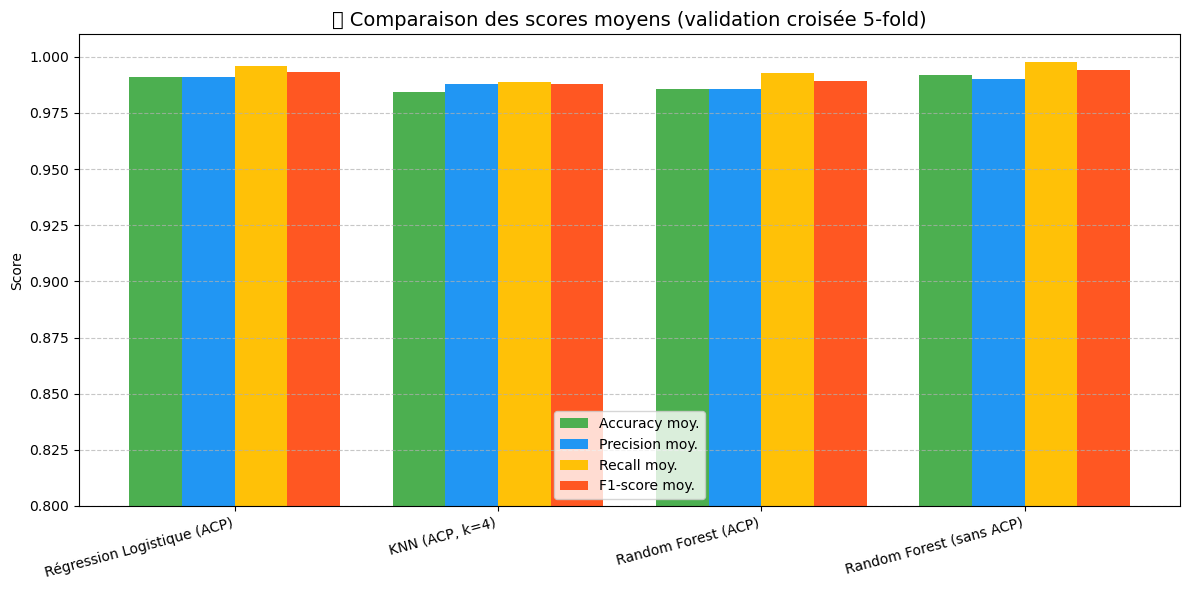

In [165]:
import matplotlib.pyplot as plt

# üìä Construction du graphique
metrics = ["Accuracy moy.", "Precision moy.", "Recall moy.", "F1-score moy."]
colors = ['#4CAF50', '#2196F3', '#FFC107', '#FF5722']

# Cr√©ation d'un graphique en barres pour chaque m√©trique
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(df_scores2))
bar_width = 0.2

for i, metric in enumerate(metrics):
    ax.bar(
        [p + bar_width * i for p in x],
        df_scores2[metric],
        width=bar_width,
        label=metric,
        color=colors[i]
    )

# üè∑Ô∏è Param√®tres du graphique
ax.set_title("üìä Comparaison des scores moyens (validation crois√©e 5-fold)", fontsize=14)
ax.set_xticks([p + bar_width * 1.5 for p in x])
ax.set_xticklabels(df_scores2.index, rotation=15, ha='right')
ax.set_ylim(0.8, 1.01)
ax.set_ylabel("Score")
ax.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


C:\Users\gabry\AppData\Local\Temp\ipykernel_19020\933135227.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


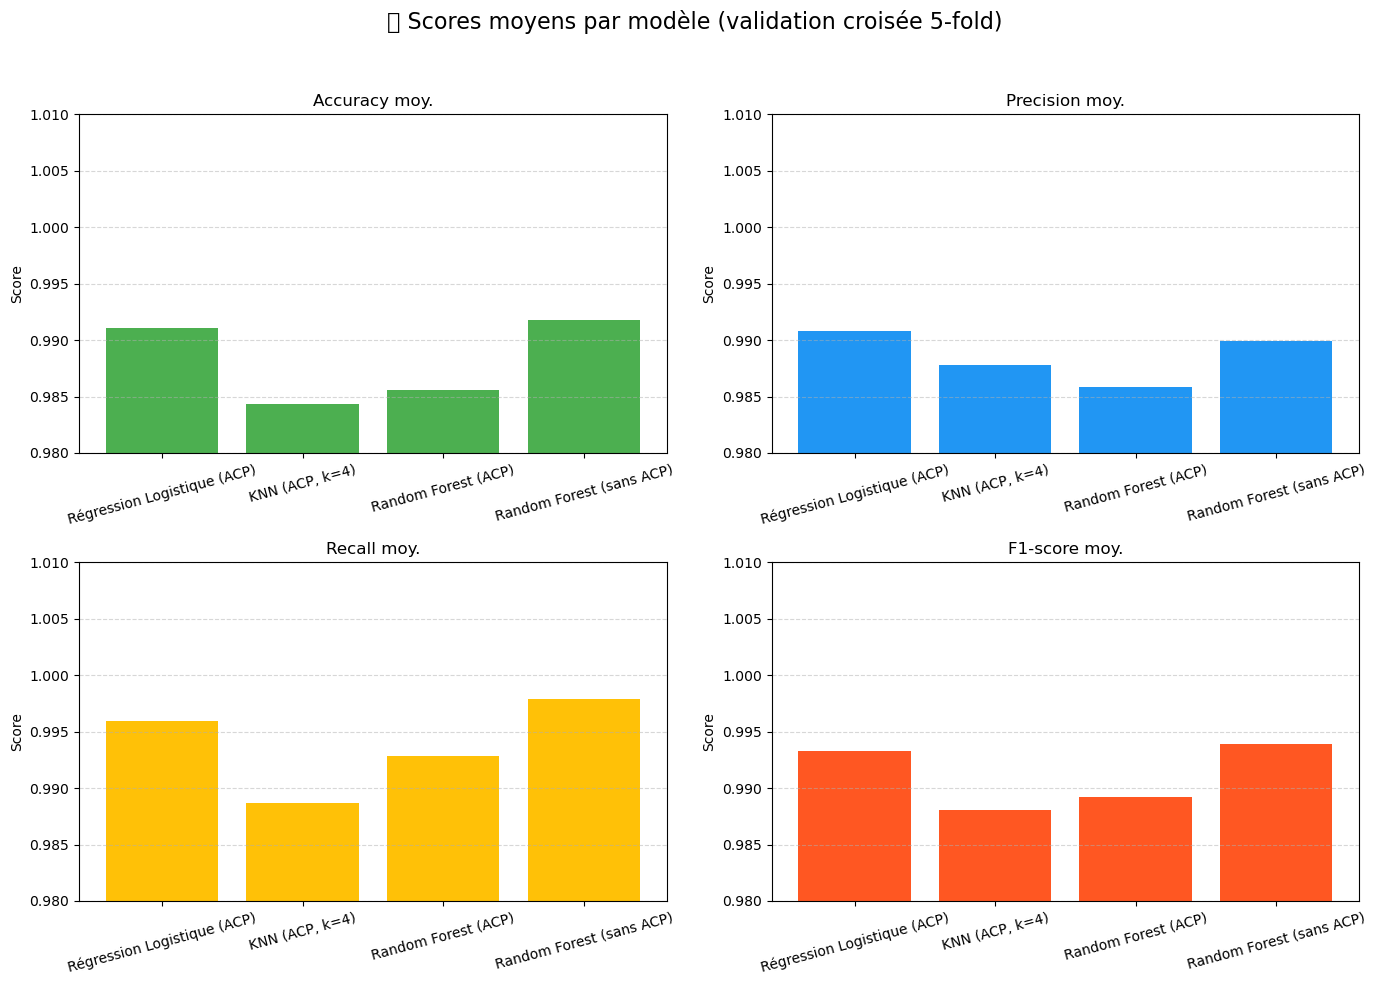

In [166]:
import matplotlib.pyplot as plt

# üìä Donn√©es √† tracer
metrics = ["Accuracy moy.", "Precision moy.", "Recall moy.", "F1-score moy."]
colors = ['#4CAF50', '#2196F3', '#FFC107', '#FF5722']

# Cr√©ation des sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    axes[i].bar(df_scores2.index, df_scores2[metric], color=colors[i])
    axes[i].set_title(f"{metric}", fontsize=12)
    axes[i].set_ylim(0.98, 1.01)
    axes[i].set_ylabel("Score")
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

# üè∑Ô∏è Mise en page
fig.suptitle("üìä Scores moyens par mod√®le (validation crois√©e 5-fold)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



# 5 Choix du mod√®le 

### M√©trique	Ce qu‚Äôelle mesure :
### Accuracy	Part des bonnes pr√©dictions sur l‚Äôensemble des observations
### Precision	Parmi les billets pr√©dits comme faux, combien sont r√©ellement faux ?
### Recall	    Parmi les billets vraiment faux, combien ont √©t√© bien d√©tect√©s comme tels ?
### F1-score	Moyenne harmonique entre pr√©cision et rappel (√©quilibre entre les deux)

### Random Forest (sans ACP) ‚Äî  Meilleur global
### Accuracy = 99.18% : Tr√®s peu d‚Äôerreurs.

### Recall = 99.79% : Presque tous les faux billets sont d√©tect√©s.

### F1-score = 0.9939 : Excellent √©quilibre entre precision et recall.

### Interpr√©tation : C‚Äôest le mod√®le le plus performant sans r√©duction de dimension, ce qui indique que la structure compl√®te des donn√©es est tr√®s utile pour les arbres de d√©cision.

### R√©gression Logistique (ACP) ‚Äî Tr√®s bon aussi
### Accuracy = 99.11%

### Recall = 99.59%

### F1-score = 0.9933

### Interpr√©tation : Excellent r√©sultat avec r√©duction de dimension. Plus l√©ger et rapide √† entra√Æner, il reste robuste. L‚ÄôACP n‚Äôa pas d√©grad√© la performance.

### KNN (ACP, k=4) ‚Äî L√©g√®rement en retrait
### Accuracy = 98.43%

### F1-score = 0.9881

### Interpr√©tation : Correct mais un peu moins pr√©cis. Le KNN est sensible √† la structure locale des donn√©es, qui peut √™tre un peu alt√©r√©e par l‚ÄôACP.

### Random Forest (avec ACP) ‚Äî Bon compromis
### Accuracy = 98.56%

### Recall = 99.28%

### Interpr√©tation : Tr√®s bon d√©tecteur de faux billets aussi, mais la r√©duction de dimension a un peu limit√© ses performances par rapport √† la version sans ACP.

### conclusion : pour maximiser la detection de faux billets se diriger vers le mod√®le random forest sans ACP (meilleur recall et F1_score)

# 5.1 Choix de la data (Comparaison score entre dataframe impl√©ment√© ou tronqu√©)

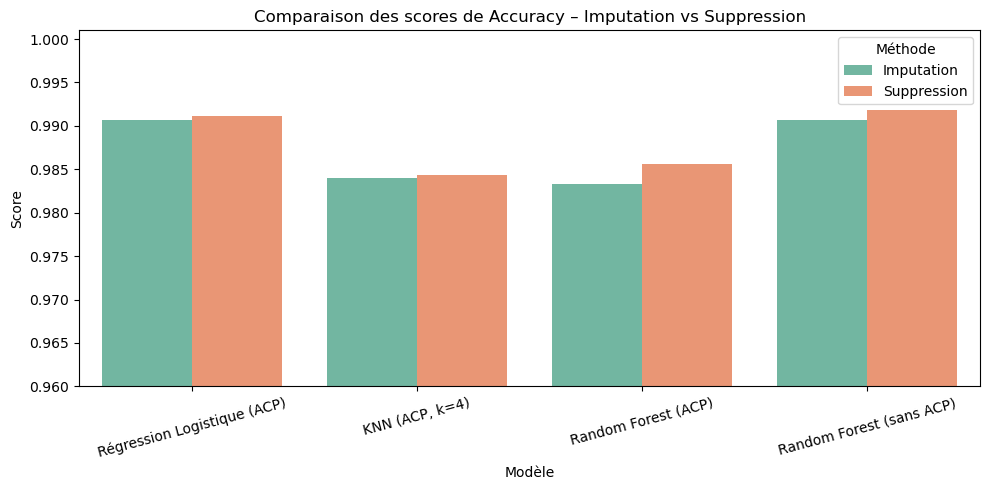

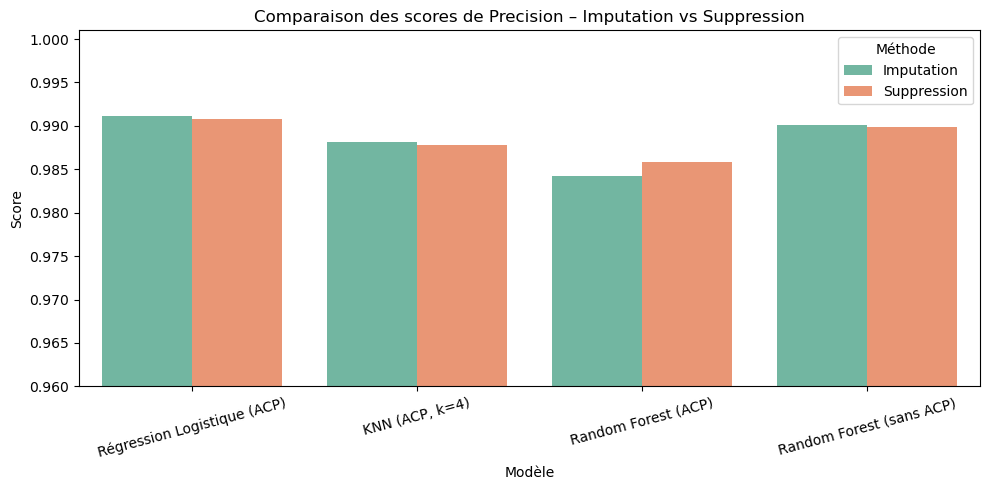

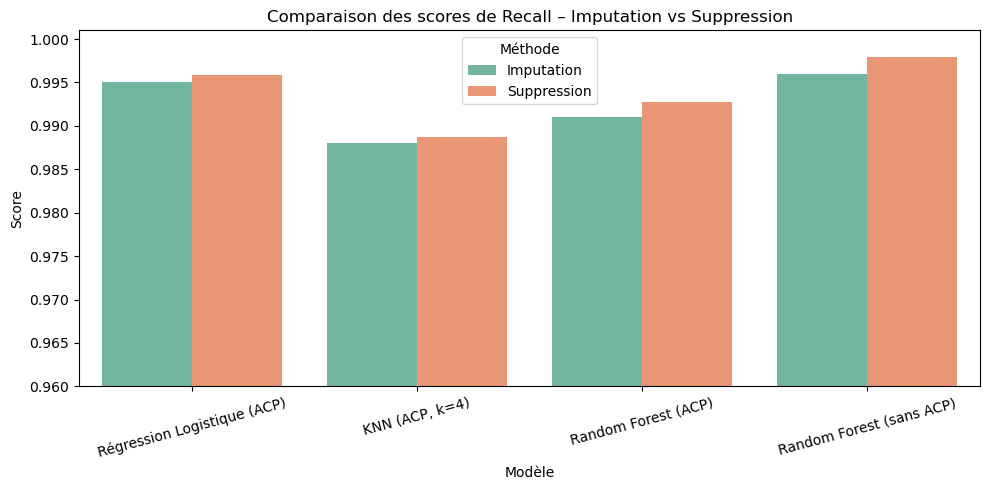

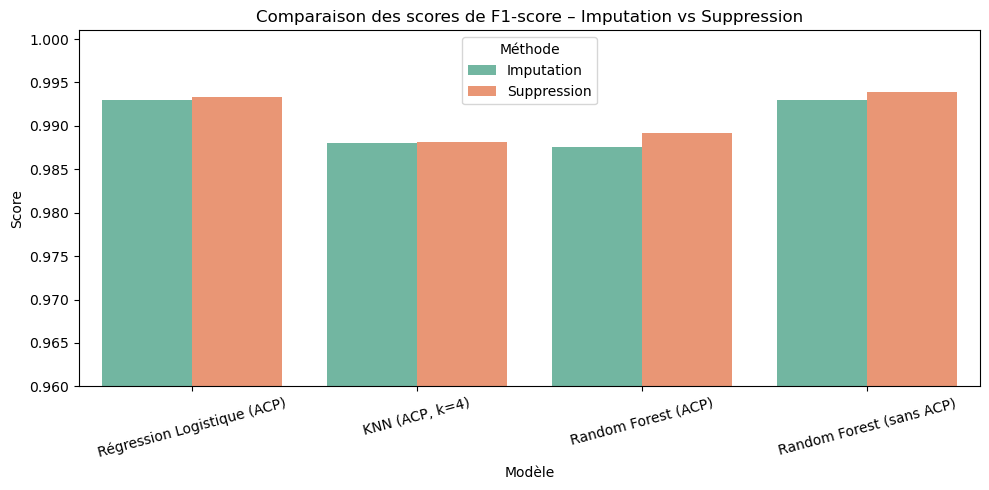

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ajouter la colonne 'Mod√®le' 
model_names = ["R√©gression Logistique (ACP)", "KNN (ACP, k=4)", "Random Forest (ACP)", "Random Forest (sans ACP)"]
df_scores1["Mod√®le"] = model_names
df_scores2["Mod√®le"] = model_names

# Ajouter la colonne 'M√©thode' 
df_scores1["M√©thode"] = "Imputation"
df_scores2["M√©thode"] = "Suppression"

# Fusion des deux jeux de scores
df_scores = pd.concat([df_scores1, df_scores2], ignore_index=True)

# Transformation longue
df_melted = df_scores.melt(
    id_vars=["Mod√®le", "M√©thode"],
    value_vars=["Accuracy moy.", "Precision moy.", "Recall moy.", "F1-score moy."],
    var_name="M√©trique",
    value_name="Score"
)

# Simplification du nom des colonnes
df_melted["M√©trique"] = df_melted["M√©trique"].str.replace(" moy.", "", regex=False)

# Affichage des graphiques (un par m√©trique)
import matplotlib.pyplot as plt
import seaborn as sns

for metric in df_melted["M√©trique"].unique():
    plt.figure(figsize=(10, 5))
    data = df_melted[df_melted["M√©trique"] == metric]
    sns.barplot(data=data, x="Mod√®le", y="Score", hue="M√©thode", palette="Set2")
    plt.title(f"Comparaison des scores de {metric} ‚Äì Imputation vs Suppression")
    plt.xticks(rotation=15)
    plt.ylim(0.96, 1.001)
    plt.tight_layout()
    plt.legend(title="M√©thode")
    plt.show()


### on notera tout de meme un leger avatange en precision avec le dataframe impl√©ment√© avec respectivement une precision de +0.003 en KNN et regression logistique et +0.002 en Random forest sans ACP sinon pour tout le reste le dataframe avec les donn√©es brutes tronqu√©es est meilleur

# 5.2 Conclusion r√©dig√©e

## R√©gression logistique (ACP)
### La r√©gression logistique, pr√©c√©d√©e d‚Äôune standardisation et d‚Äôune r√©duction dimensionnelle par ACP (5 composantes), atteint une accuracy moyenne de 99,11 %, avec une pr√©cision de 99,08 %, un rappel de 99,59 % et un F1-score de 99,33 % en validation crois√©e 5-fold. Ces performances t√©moignent d‚Äôune excellente capacit√© du mod√®le √† distinguer les vrais billets des faux, m√™me apr√®s projection des donn√©es dans un espace r√©duit. L‚ÄôACP contribue ici √† limiter le risque de surapprentissage tout en conservant une forte capacit√© discriminante.

## K-plus proches voisins (KNN, ACP)
### Le mod√®le KNN, appliqu√© apr√®s standardisation et ACP, avec un nombre optimal de voisins fix√© √† 4, obtient une accuracy moyenne de 98,43 %, une pr√©cision de 98,78 %, un rappel de 98,87 % et un F1-score de 98,81 %. Bien que l√©g√®rement inf√©rieur √† la r√©gression logistique, il montre une bonne capacit√© de classification, mais sa d√©pendance √† la structure locale des donn√©es le rend plus sensible aux variations et au bruit.

## For√™t al√©atoire (ACP)
### La for√™t al√©atoire, appliqu√©e apr√®s standardisation et ACP, affiche une accuracy moyenne de 98,56 %, une pr√©cision de 98,58 %, un rappel de 99,28 % et un F1-score de 98,92 %. L‚Äôutilisation de l‚ÄôACP permet ici de r√©duire la dimensionnalit√©, mais la l√©g√®re perte d‚Äôinformation par rapport au mod√®le sans ACP se traduit par une performance l√©g√®rement inf√©rieure, bien que toujours excellente.

## For√™t al√©atoire (sans ACP)
### La for√™t al√©atoire appliqu√©e directement sur les variables standardis√©es, sans r√©duction dimensionnelle, obtient la meilleure performance globale : accuracy moyenne de 99,18 %, pr√©cision de 98,99 %, rappel de 99,79 % et F1-score de 99,39 %. L‚Äôabsence d‚ÄôACP lui permet de tirer pleinement parti de toutes les informations pr√©sentes dans les variables d‚Äôorigine, expliquant ses scores l√©g√®rement sup√©rieurs aux autres mod√®les supervis√©s.

# Conclusion

### Le mod√®le Random Forest sans ACP a √©t√© retenu car il offre un excellent compromis entre pr√©cision, rappel et robustesse. Avec un recall de 99,79 %, il minimise drastiquement les faux n√©gatifs (c‚Äôest-√†-dire les faux billets class√©s √† tort comme vrais), ce qui est critique dans un contexte de d√©tection de fraude. Par ailleurs, il conserve une pr√©cision √©lev√©e (98,99 %), ce qui limite aussi les faux positifs, √©vitant ainsi de rejeter des billets authentiques.

### L‚Äôabsence d‚ÄôACP permet de conserver l‚Äôint√©gralit√© de l‚Äôinformation port√©e par les variables d‚Äôorigine, ce qui am√©liore l‚Äôinterpr√©tabilit√© des r√©sultats et facilite la mise en production. Enfin, la nature m√™me de la Random Forest lui conf√®re une grande robustesse face aux donn√©es bruit√©es et aux valeurs extr√™mes, assurant des performances stables sur de nouveaux jeux de donn√©es.

### En r√©sum√© : la Random Forest sans ACP est non seulement la plus performante mais aussi la plus robuste, et donc le meilleur choix pour un d√©ploiement op√©rationnel dans ce contexte.


# 6 Sauvegarde du mod√®le

In [183]:
import joblib
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Jeu final : df_complete (d√©j√† nettoy√© : margin_low non-null)
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df_complete[features]
y = df_complete['is_genuine']

# Pipeline final
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
])

# Entra√Ænement sur TOUT df_complete
rf_pipeline.fit(X, y)

# Sauvegarde du pipeline et des features utilis√©es
joblib.dump({"pipeline": rf_pipeline, "features": features}, "rf_no_pca_pipeline.joblib")
print(" Mod√®le sauvegard√© : rf_no_pca_pipeline.joblib")


 Mod√®le sauvegard√© : rf_no_pca_pipeline.joblib
